In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import random
import sys

import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
import prettypyplot as pplt

In [3]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [4]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [5]:
sys.path.insert(0, "/project/dinner/scguo/kaiB/src")
import statistics

import data
import utils

In [6]:
plt.style.use("custom")  # custom style sheet
plt.style.use("high-contrast")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [7]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [8]:
home_dir = "/project/dinner/scguo/kaiB"
figure_dir = "/project/dinner/scguo/kaiB/dga/figures"

# Loading data

In [9]:
# for t in [91]:
#     base_dir = f"{home_dir}/dga/new_{t}"
#     data_dir = f"{base_dir}/data"
#     ids = data.get_traj_ids(base_dir)
#     np.savetxt(f"{data_dir}/traj_ids.txt", ids, fmt="%.05d")

In [10]:
# print(len(ids))

In [11]:
cvs_all_ts, weights_all_ts = [], []
qp_all_ts = []
qlag, qmem = 100, 1
for t in [87, 89, 91]:
    cvs, weights = data.load_all(t)
    cvs_all_ts.append(cvs)
    weights_all_ts.append(weights)
    with open(f"{home_dir}/dga/new_{t}/data/qp_gs2fs.pkl", mode="rb") as f:
        qp_all_ts.append(dill.load(f)[(qlag, qmem)])

In [12]:
labels = dict(
    blue=r"$Q_{\mathrm{fs}, \alpha3}-Q_{\mathrm{gs}, \beta4}$",
    green=r"$Q_{\mathrm{fs}, \beta4}-Q_{\mathrm{gs}, \alpha3}$",
    orange=r"$Q_{\mathrm{fs} ,\beta3}-Q_{\mathrm{gs}, \alpha2}$",
    c0=r"$Q_{\mathrm{fs}, \alpha2}-Q_{\mathrm{gs}, \beta3}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{fs, C}}-Q_{\mathrm{gs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1.3, 1),
    green=(-1, 1.3),
    orange=(-1, 1.3),
    c0=(-1.3, 1),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

# Projections

/scratch/local/jobs/20606506/ipykernel_3481503/317744930.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
/scratch/local/jobs/20606506/ipykernel_3481503/317744930.py:31: RuntimeWarning: invalid value encountered in divide
  contour = ax.contour(xc, yc, (qw / w).T, levels=[0.5])
/scratch/local/jobs/20606506/ipykernel_3481503/317744930.py:33: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_paths = contour.collections[level_index].get_paths()


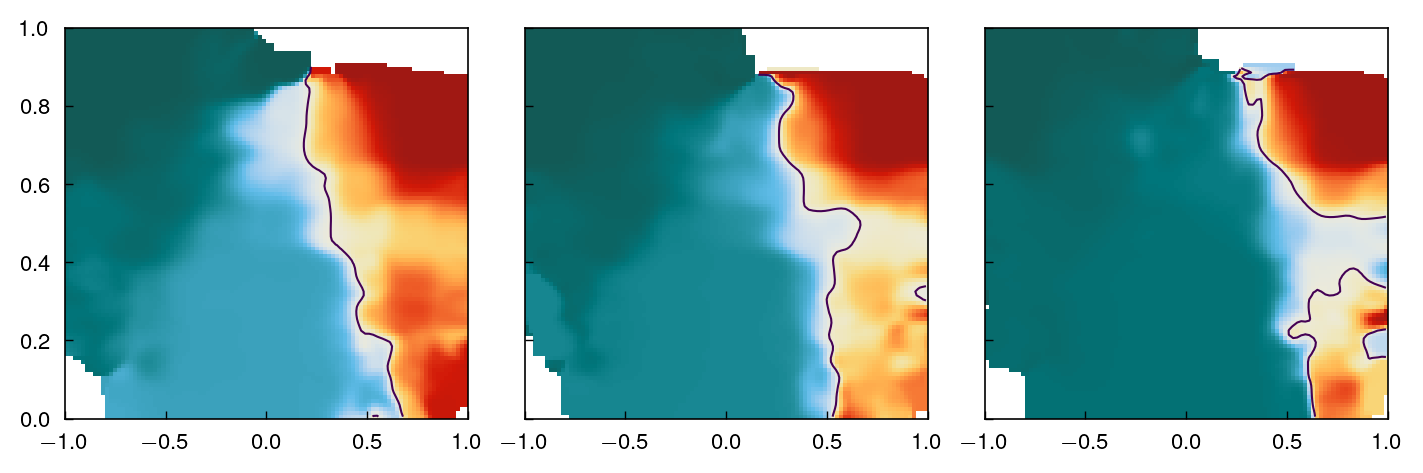

In [39]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
tse_points = []
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = cvs[cv1][..., :-qlag]
    cv2_delay = cvs[cv2][..., :-qlag]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=1.5, mode="constant")
    qw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(qp)[..., :-qlag] * sample_w[..., None],
        xe,
        ye,
    )
    qw = scipy.ndimage.gaussian_filter(qw, sigma=1.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
    contour = ax.contour(xc, yc, (qw / w).T, levels=[0.5])
    level_index = 0
    contour_paths = contour.collections[level_index].get_paths()

    # Extract points from the contour line
    points = []
    for path in contour_paths:
        points.extend(path.vertices)

    # Convert the points to a NumPy array for easier manipulation
    points = np.array(points)
    tse_points.append(points)

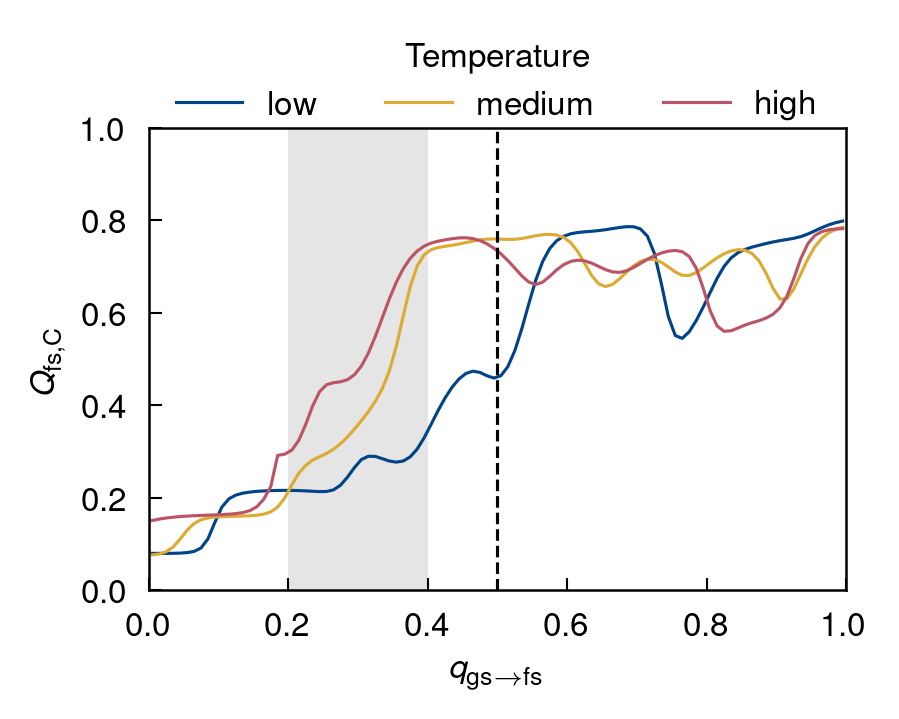

In [12]:
fig = plt.figure(figsize=(3, 2), dpi=300)
cv1 = "q_fs"

lag, mem = 100, 1
xstd = 0.03

for qp, w, cvs in zip(qp_all_ts, weights_all_ts, cvs_all_ts):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    numer, xe = utils.kdesum1d(q, cvs[cv1][..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=100)
    denom, _ = utils.kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
    xc = (xe[1:] + xe[:-1]) / 2
    plt.plot(xc, numer / denom)
plt.axvspan(0.2, 0.4, ec=None, color="gray", alpha=0.2)
plt.axvline(0.5, color="black", ls="--")
plt.xlabel(labels["qp"])
plt.ylabel(labels[cv1])
plt.xlim([0, 1])
plt.ylim(lims[cv1])
plt.legend(["low", "medium", "high"], title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3)
fig.savefig(f"{figure_dir}/qp_qfs_ts.pdf", bbox_inches="tight")

In [46]:
tse_masks = []
tse0, tse1, tse2 = tse_points
mask0 = np.ones(len(tse0), dtype=bool)
mask0[:4] = False
tse_masks.append(mask0)
tse_masks.append((tse1[:, 0] < 0.8))
tse_masks.append((tse2[:, 1] < 0.83) & (tse2[:, 1] > 0.4))

/scratch/local/jobs/18762625/ipykernel_2538/154299017.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


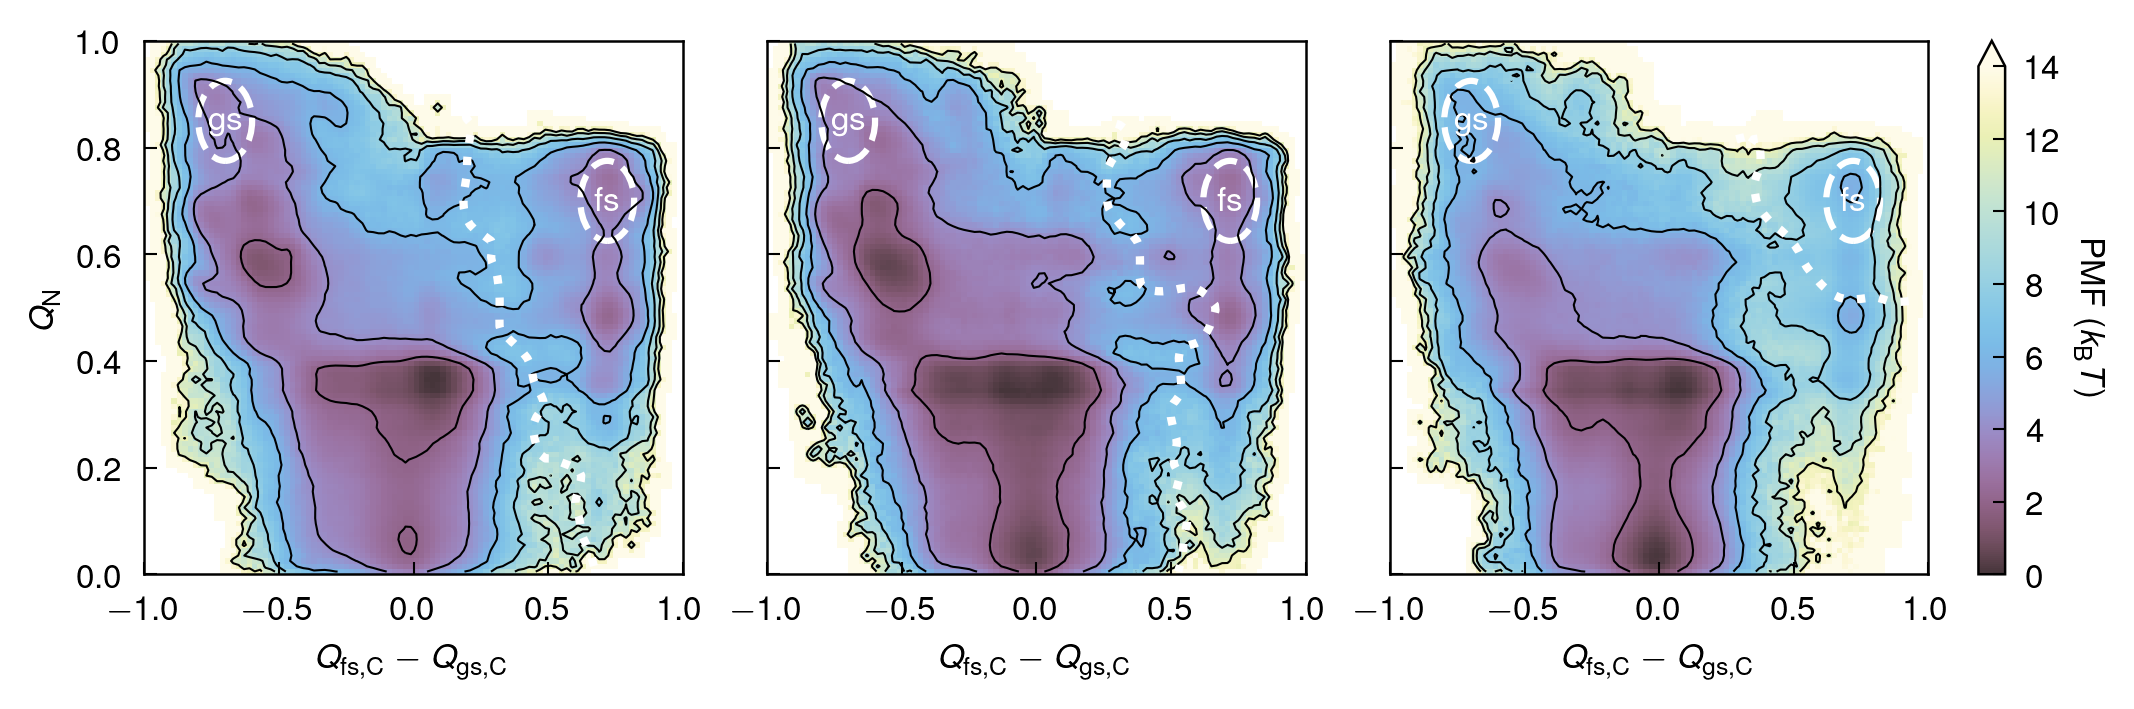

In [48]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, tse, mask in zip(axes, cvs_all_ts, weights_all_ts, tse_points, tse_masks):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.plot(tse[mask, 0], tse[mask, 1], color="white", ls=":", lw=2)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(-0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(-0.7, 0.85, "gs", ax=ax, color="white")
    pplt.text(0.72, 0.7, "fs", ax=ax, color="white")
fig.savefig(f"{figure_dir}/pmfs_qdiff_qcore_ts_tse.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/20766144/ipykernel_1394534/4258413547.py:25: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


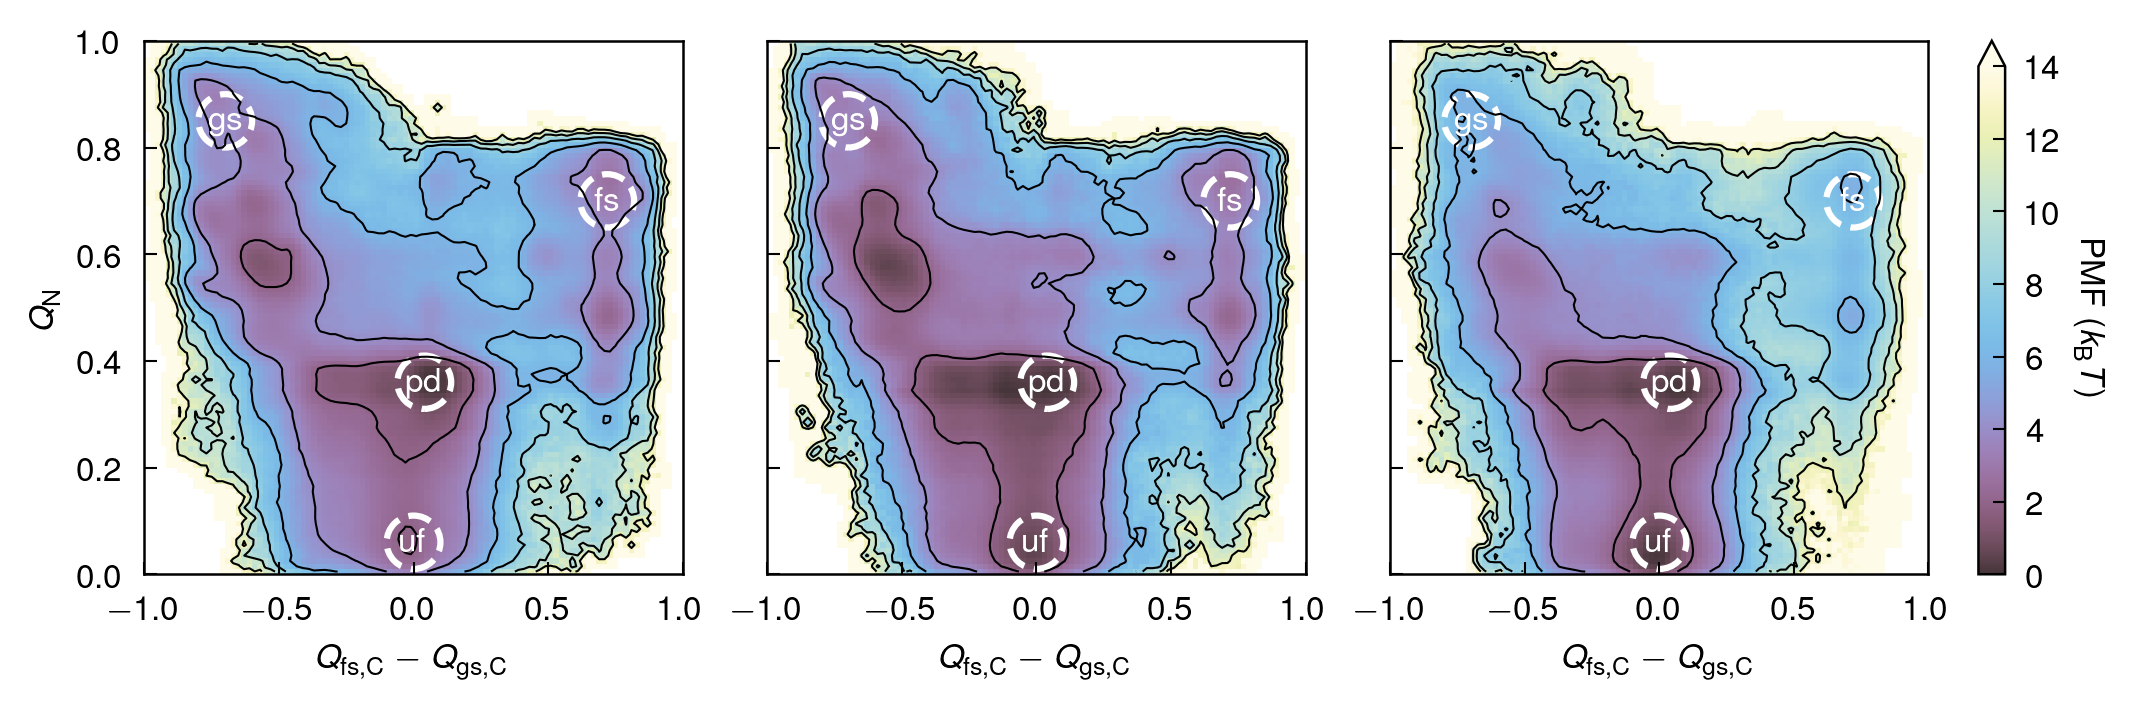

In [36]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
X, Y = np.meshgrid(xc, yc)
pmfs = []

for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pmfs.append(pmf)
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

centers = [(-0.7, 0.85), (0.72, 0.7), (0.04, 0.36), (0, 0.06)]
radii = [(0.2, 0.1), (0.2, 0.1), (0.2, 0.1), (0.2, 0.1)]
names = ["gs", "fs", "pd", "uf"]
for ax in axes:
    for (c1, c2), (r1, r2), label in zip(centers, radii, names):
        e = mpl.patches.Ellipse(xy=(c1, c2), width=r1, height=r2)
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
        ax.add_artist(e)
        pplt.text(c1, c2, label, ax=ax, color="white")
fig.savefig(f"{figure_dir}/pmfs_qdiff_qcore_ts_states.pdf", bbox_inches="tight", dpi=400)

In [23]:
names = ["gs", "fs", "pd", "uf"]

# gs = ((X + 0.7) ** 2 / 0.1**2) + ((Y - 0.85) ** 2 / 0.05**2) < 1
# fs = ((X - 0.72) ** 2 / 0.1**2) + ((Y - 0.7) ** 2 / 0.05**2) < 1
# pd = (X**2 / 0.1**2) + ((Y - 0.38) ** 2 / 0.05**2) < 1
# uf = (X**2 / 0.1**2) + ((Y - 0.06) ** 2 / 0.05**2) < 1
for T, pmf in zip([0.87, 0.89, 0.91], pmfs):
    print(f"T = {T:.2f}")
    for (c1, c2), label in zip(centers, names) :
        state = ((X - c1) ** 2 / 0.05**2) + ((Y - c2) ** 2 / 0.02**2) < 1
        notinf = (pmf[state] != np.inf)
        print(f"{label}: {np.mean(pmf[state], where=notinf):.1f} [{np.count_nonzero(notinf)}]")
    print("")

T = 0.87
gs: 8.5 [16]
fs: 23.8 [3]
pd: 4.5 [16]
uf: 12.6 [16]

T = 0.89
gs: 8.0 [16]
fs: 26.9 [7]
pd: 3.0 [16]
uf: 10.7 [16]

T = 0.91
gs: 11.9 [16]
fs: 27.1 [12]
pd: 4.2 [16]
uf: 11.8 [16]



In [26]:
def g_state(w, in_state):
    return -np.log(np.sum(np.repeat(w[..., None], 1001, axis=1)[in_state]))

In [37]:
names = ["gs", "fs", "pd", "uf"]
cv1 = "q_diff"
cv2 = "q_core"

for T, cvs, sample_w in zip([0.87, 0.89, 0.91], cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    print(f"T = {T:.2f}")
    offset = np.inf
    gs = []
    for (c1, c2), label in zip(centers, names):
        state = ((cv1_delay - c1) ** 2 / 0.1**2) + ((cv2_delay - c2) ** 2 / 0.05**2) < 1
        g = g_state(sample_w, state)
        if g < offset:
            offset = g
        gs.append(g)
    for g, label in zip(gs, names):
        print(f"{label}: {g - offset:.1f}")
    print("")

T = 0.87
gs: 3.3
fs: 2.8
pd: 0.0
uf: 1.7

T = 0.89
gs: 3.1
fs: 2.9
pd: 0.0
uf: 0.6

T = 0.91
gs: 5.4
fs: 5.9
pd: 0.0
uf: 0.1



/scratch/local/jobs/18656226/ipykernel_1644698/3028431144.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)


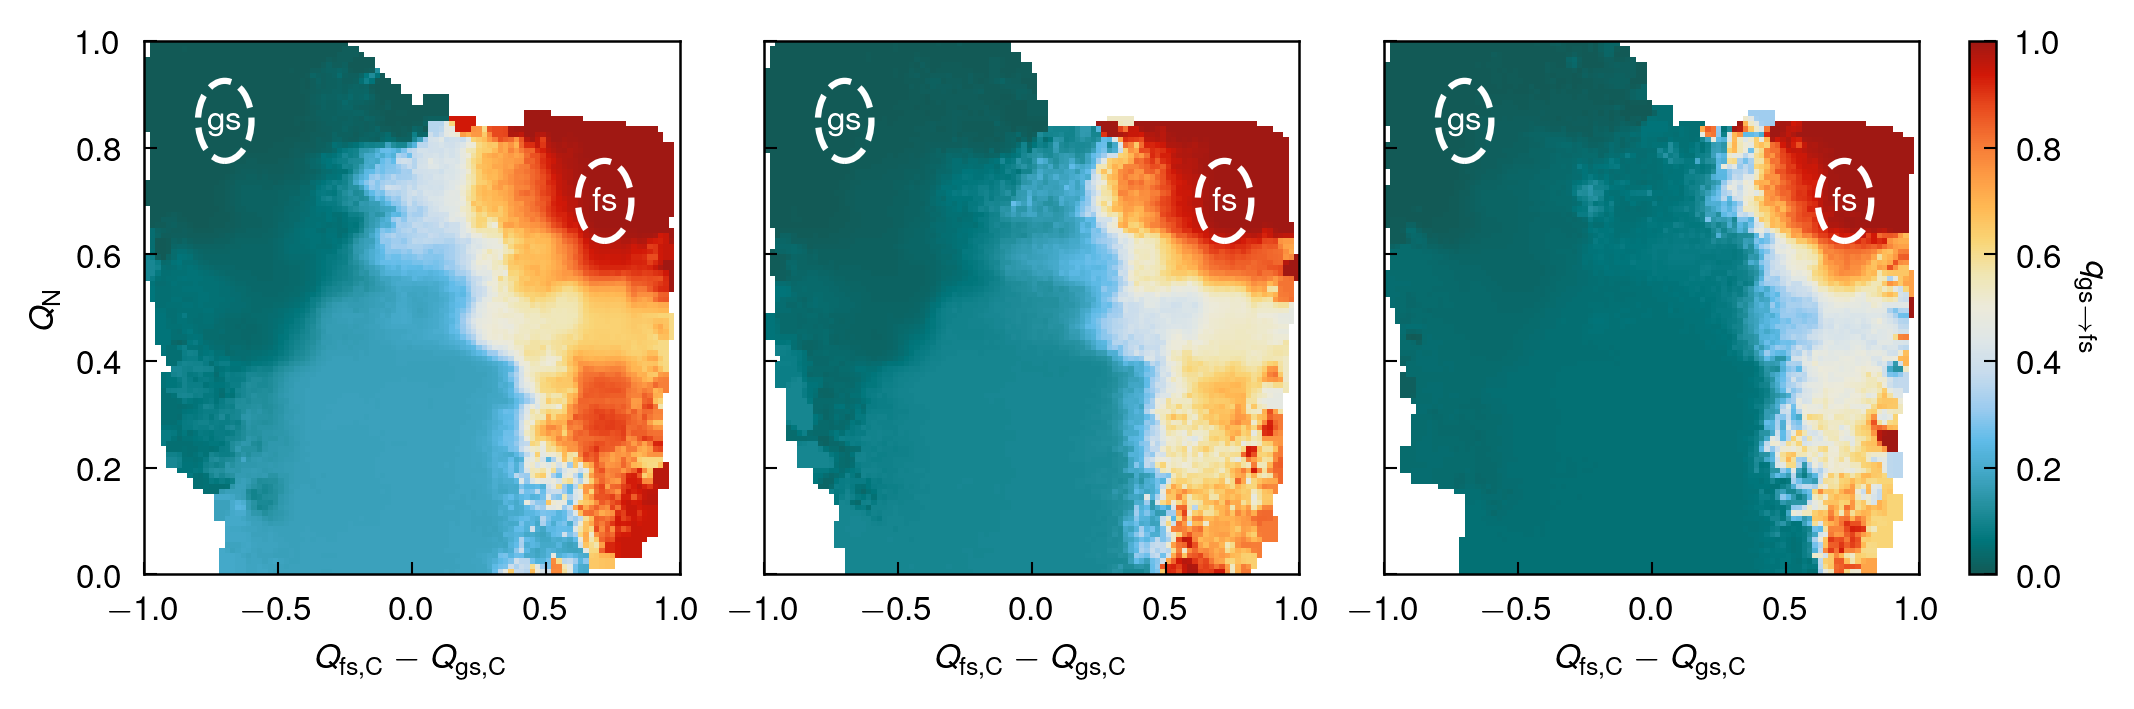

In [14]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = cvs[cv1][..., :-qlag]
    cv2_delay = cvs[cv2][..., :-qlag]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    qw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(qp)[..., :-qlag] * sample_w[..., None],
        xe,
        ye,
    )
    qw = scipy.ndimage.gaussian_filter(qw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=labels["qp"], rotation=-90, labelpad=10)


for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(-0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(-0.7, 0.85, "gs", ax=ax, color="white")
    pplt.text(0.72, 0.7, "fs", ax=ax, color="white")
fig.savefig(f"{figure_dir}/qp_gs2fs_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18762625/ipykernel_2538/2040398274.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)


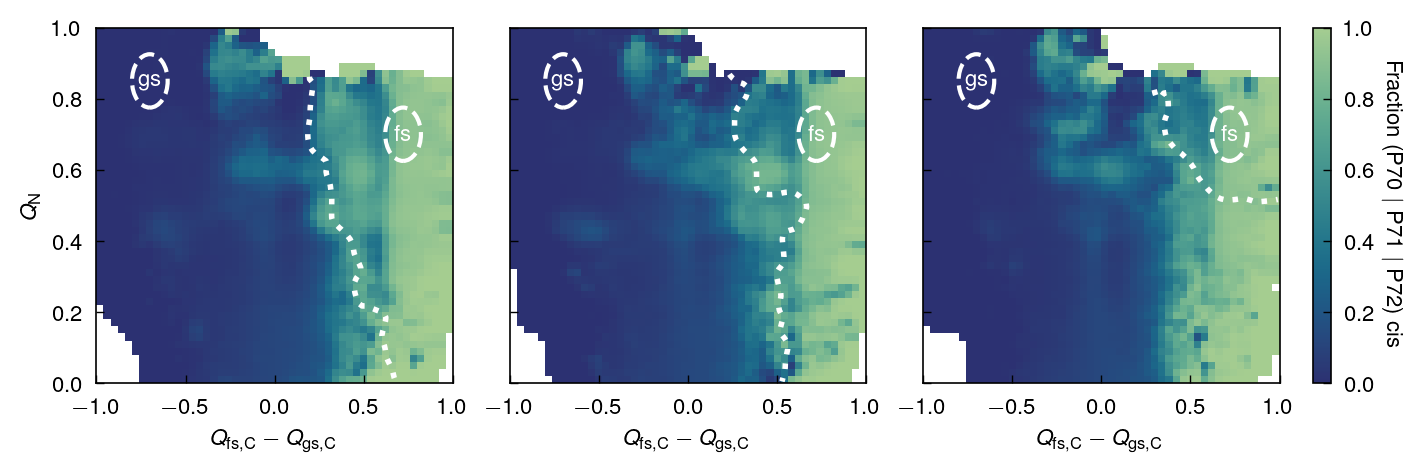

In [66]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, tse, mask in zip(axes, cvs_all_ts, weights_all_ts, tse_points, tse_masks):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs["p70"] | cvs["p71"] | cvs["p72"]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=1, rasterized=True)
    ax.plot(tse[mask, 0], tse[mask, 1], color="white", ls=":", lw=2)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=r"Fraction (P70 $|$ P71 $|$ P72) cis", rotation=-90, labelpad=10)

for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(-0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(-0.7, 0.85, "gs", ax=ax, color="white")
    pplt.text(0.72, 0.7, "fs", ax=ax, color="white")
fig.savefig(f"{figure_dir}/p7072_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18762625/ipykernel_2538/1857264924.py:31: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=0.3, rasterized=True)


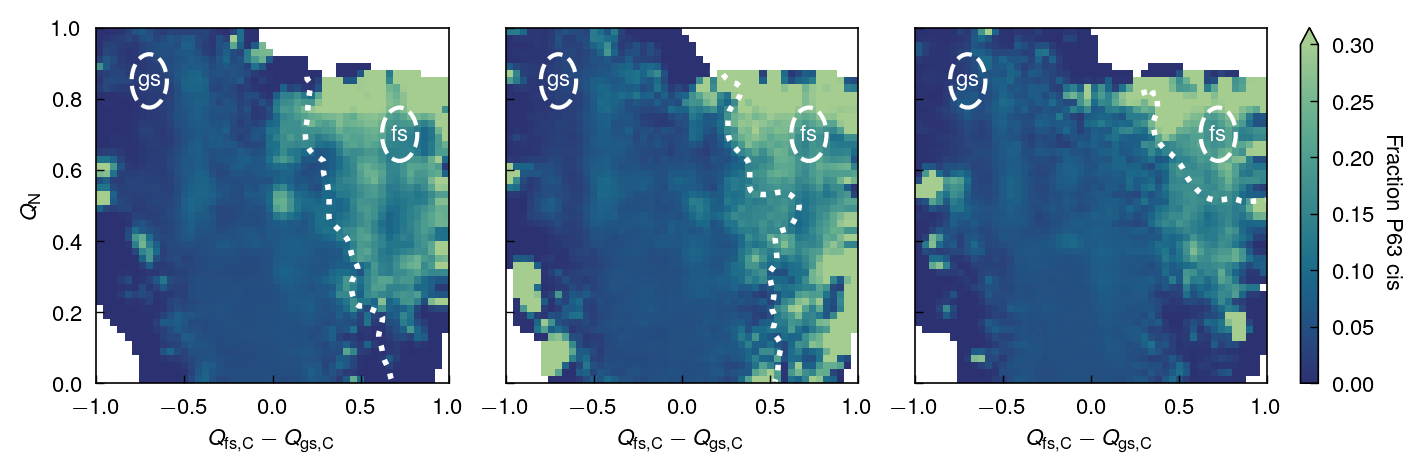

In [76]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
cv3 = "p63"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, tse, mask in zip(axes, cvs_all_ts, weights_all_ts, tse_points, tse_masks):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs[cv3]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="crest_r", vmin=0, vmax=0.3, rasterized=True)
    ax.plot(tse[mask, 0], tse[mask, 1], color="white", ls=":", lw=2)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"Fraction P63 cis", rotation=-90, labelpad=10)

for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(-0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(-0.7, 0.85, "gs", ax=ax, color="white")
    pplt.text(0.72, 0.7, "fs", ax=ax, color="white")
fig.savefig(f"{figure_dir}/p63_qdiff_qcore_ts.pdf", bbox_inches="tight", dpi=400)

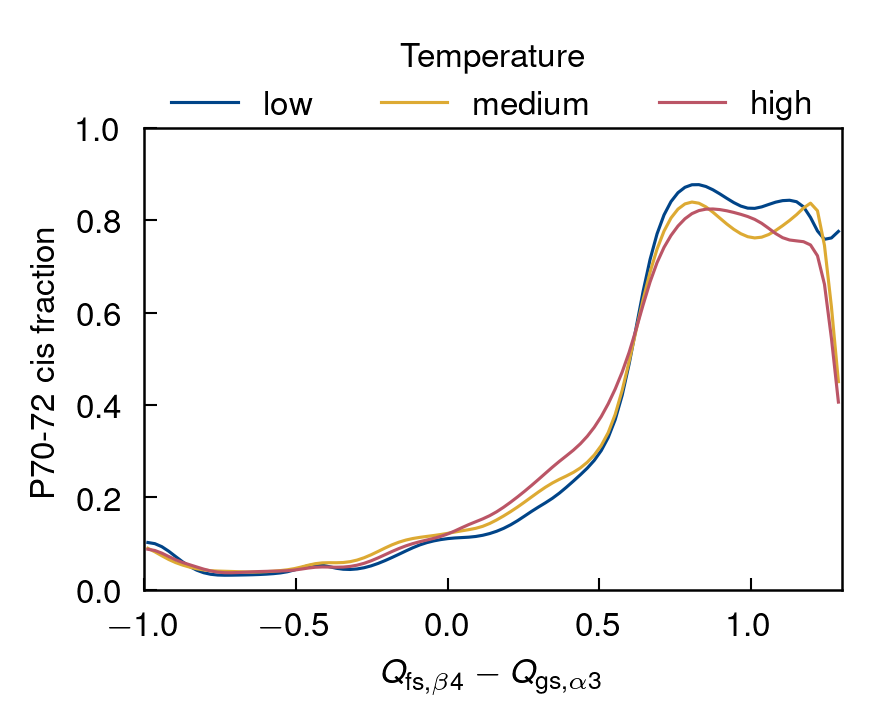

In [77]:
# combine p70-p72
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.04
nx = 100
handles = []
labs = ["low", "medium", "high"]
cv = "green"
for w, cvs, label in zip(weights_all_ts, cvs_all_ts, labs):
    x = np.asarray(cvs[cv])
    w = np.broadcast_to(w[..., None], x.shape)
    y = cvs["p70"] | cvs["p71"] | cvs["p72"]
    numer, xe = utils.kdesum1d(x, y * w, xmin=lims[cv][0], xmax=lims[cv][1], xstd=xstd, nx=nx)
    denom, _ = utils.kdesum1d(x, w, xmin=lims[cv][0], xmax=lims[cv][1], xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(labels[cv])
plt.ylabel("P70-72 cis fraction")
plt.xlim(lims[cv])
plt.ylim([0, 1])
plt.legend(title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3)
fig.savefig(f"{figure_dir}/green_p7072_ts.pdf", bbox_inches="tight")
plt.show()

/scratch/local/jobs/18762625/ipykernel_2538/2708076630.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


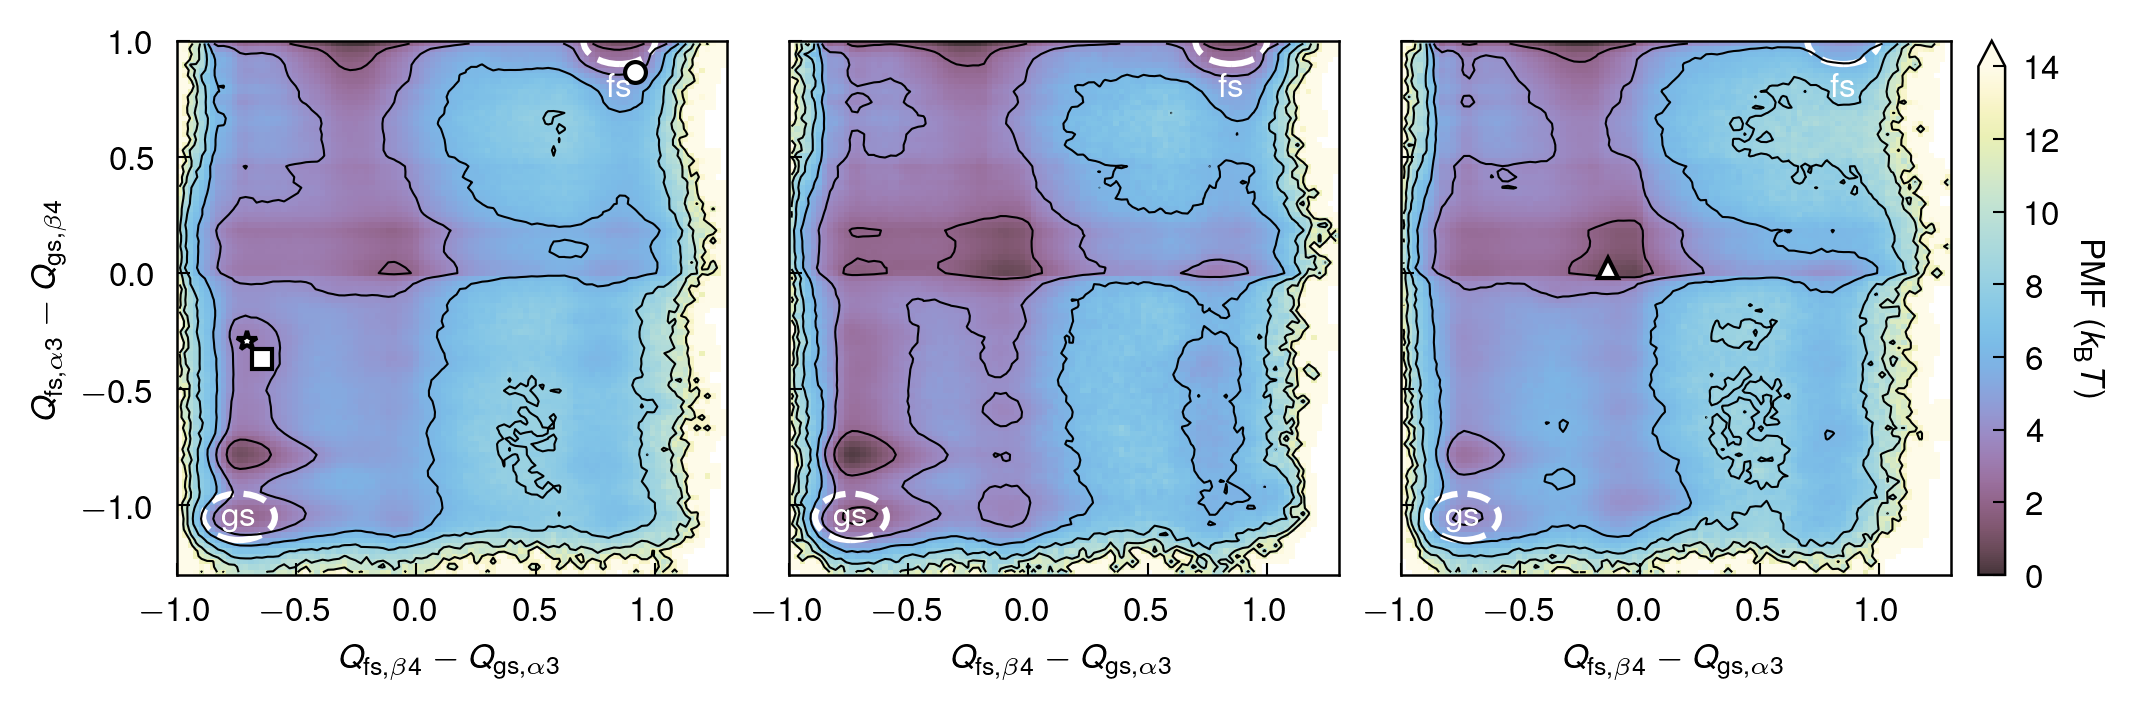

In [95]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, tse, mask in zip(axes, cvs_all_ts, weights_all_ts, tse_points, tse_masks):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    # ax.plot(tse[mask, 0], tse[mask, 1], color='white', ls=':', lw=2)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

# structures shown in PMFs
msall = ["s", "o", "*", "^"]
traj_ids = [(6663, 1), (4365, 100), (12311, 0), (21542, 5)]
dataids = [0, 0, 0, 2]
for (traj, frame), ms, dataid in zip(traj_ids, msall, dataids):
    axes[dataid].plot(
        cvs_all_ts[dataid][cv1][traj, frame],
        cvs_all_ts[dataid][cv2][traj, frame],
        ms,
        color="white",
        ms=5,
        mec="k",
    )

for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(-0.74, -1.05), width=0.3, height=0.2)
    ellipseB = mpl.patches.Ellipse(xy=(0.85, 1.0), width=0.3, height=0.2)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(-0.74, -1.05, "gs", ax=ax, color="white")
    pplt.text(0.85, 0.8, "fs", ax=ax, color="white")
fig.savefig(f"{figure_dir}/pmfs_gb_ts.pdf", bbox_inches="tight", dpi=400)

/scratch/local/jobs/18762625/ipykernel_2538/761894600.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


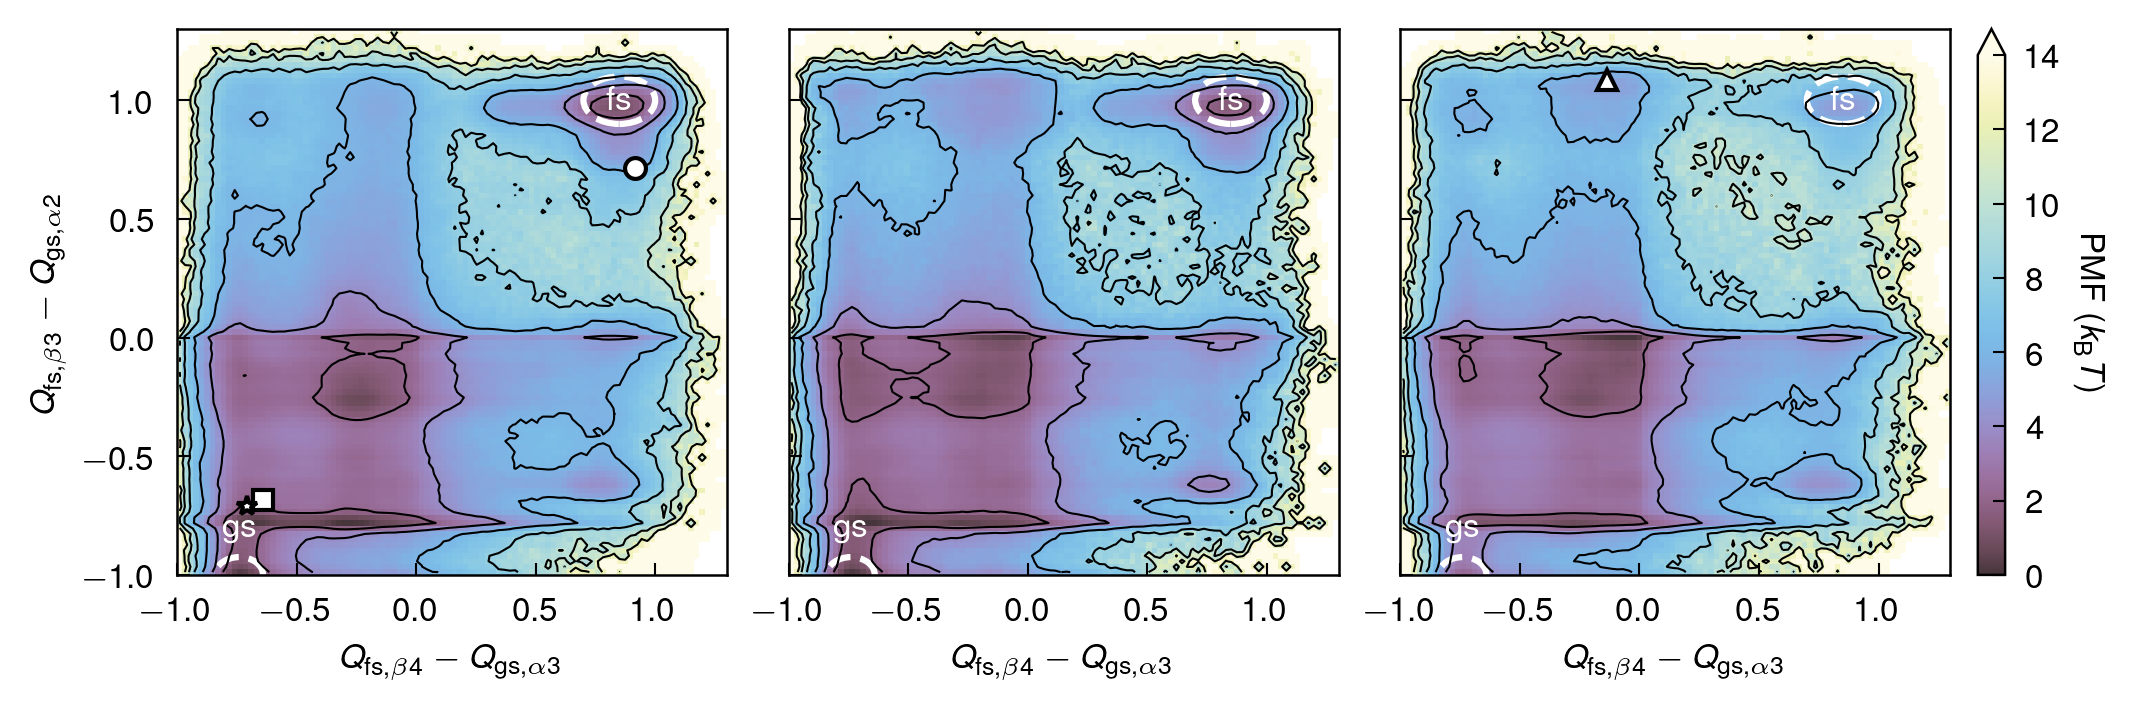

In [96]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "green"
cv2 = "orange"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, tse, mask in zip(axes, cvs_all_ts, weights_all_ts, tse_points, tse_masks):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    # ax.plot(tse[mask, 0], tse[mask, 1], color='white', ls=':', lw=2)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

# structures shown in PMFs
msall = ["s", "o", "*", "^"]
traj_ids = [(6663, 1), (4365, 100), (12311, 0), (21542, 5)]
dataids = [0, 0, 0, 2]
for (traj, frame), ms, dataid in zip(traj_ids, msall, dataids):
    axes[dataid].plot(
        cvs_all_ts[dataid][cv1][traj, frame],
        cvs_all_ts[dataid][cv2][traj, frame],
        ms,
        color="white",
        ms=5,
        mec="k",
    )

for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(-0.74, -1.0), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(0.85, 1.0), width=0.3, height=0.2)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(-0.74, -0.8, "gs", ax=ax, color="white")
    pplt.text(0.85, 1.0, "fs", ax=ax, color="white")
fig.savefig(f"{figure_dir}/pmfs_go_ts.pdf", bbox_inches="tight", dpi=400)

## 3D PMFs

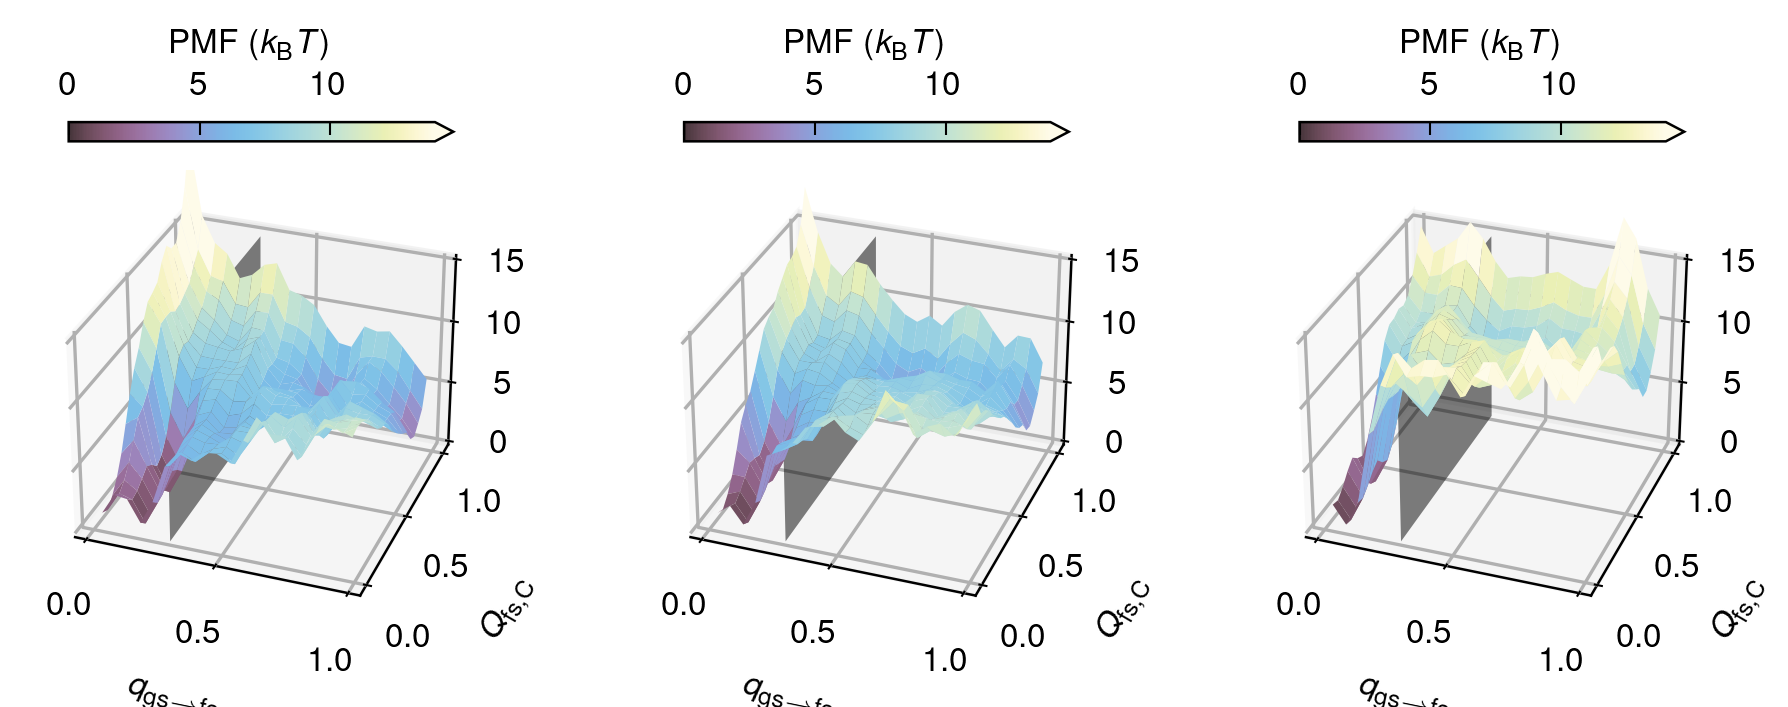

In [116]:
cv2 = "q_fs"
fig, axes = plt.subplots(1, 3, dpi=300, figsize=(7.5, 2.5), subplot_kw={"projection": "3d"})
xe = np.linspace(0, 1, 21)
ye = np.linspace(*lims[cv2], 21)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
gszs = [2, 2, 2]
fszs = [4, 5, 8]
for ax, cvs, sample_w, qp, gsz, fsz in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts, gszs, fszs):
    cv1_delay = qp
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv2_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.nanmin(-np.log(hist))

    # plane through q = 0.3
    Y, Z = np.meshgrid(np.linspace(0, 1, 2), np.linspace(0, 15, 2))
    X_plane = np.full_like(Y, 0.3)
    ax.plot_surface(X_plane, Y, Z, alpha=0.5, color="black", zorder=5)

    X, Y = np.meshgrid(xc, yc)
    ax.plot_surface(X, Y, pmf.T, cmap="iridescent_r", vmin=0, vmax=14)

    ax.set_aspect("auto")
    ax.tick_params(axis="both", which="major", pad=0.5)
    ax.set_xlabel(labels["qp"], labelpad=0.5)
    ax.set_ylabel(labels[cv2], labelpad=0.5)
    ax.grid(True)
    ax.set_zlim([0, 15])
    cb = plt.colorbar(
        pc, ax=ax, extend="max", location="top", label=r"PMF ($k_{\mathrm{B}}T$)", shrink=0.75
    )
    ax.view_init(azim=-70, elev=30)
    # ax.text(0.1, 0.1, gsz, "gs", color='k', ha='center', va='center')
    # ax.text(0.9, 0.9, fsz, "fs", color='k', ha='center', va='center')
fig.savefig(f"{figure_dir}/pmf_3d_qp_qfs_ts.pdf", bbox_inches="tight", pad_inches=0.25)

/scratch/local/jobs/18762625/ipykernel_2538/2551251590.py:20: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.nanmin(-np.log(hist))


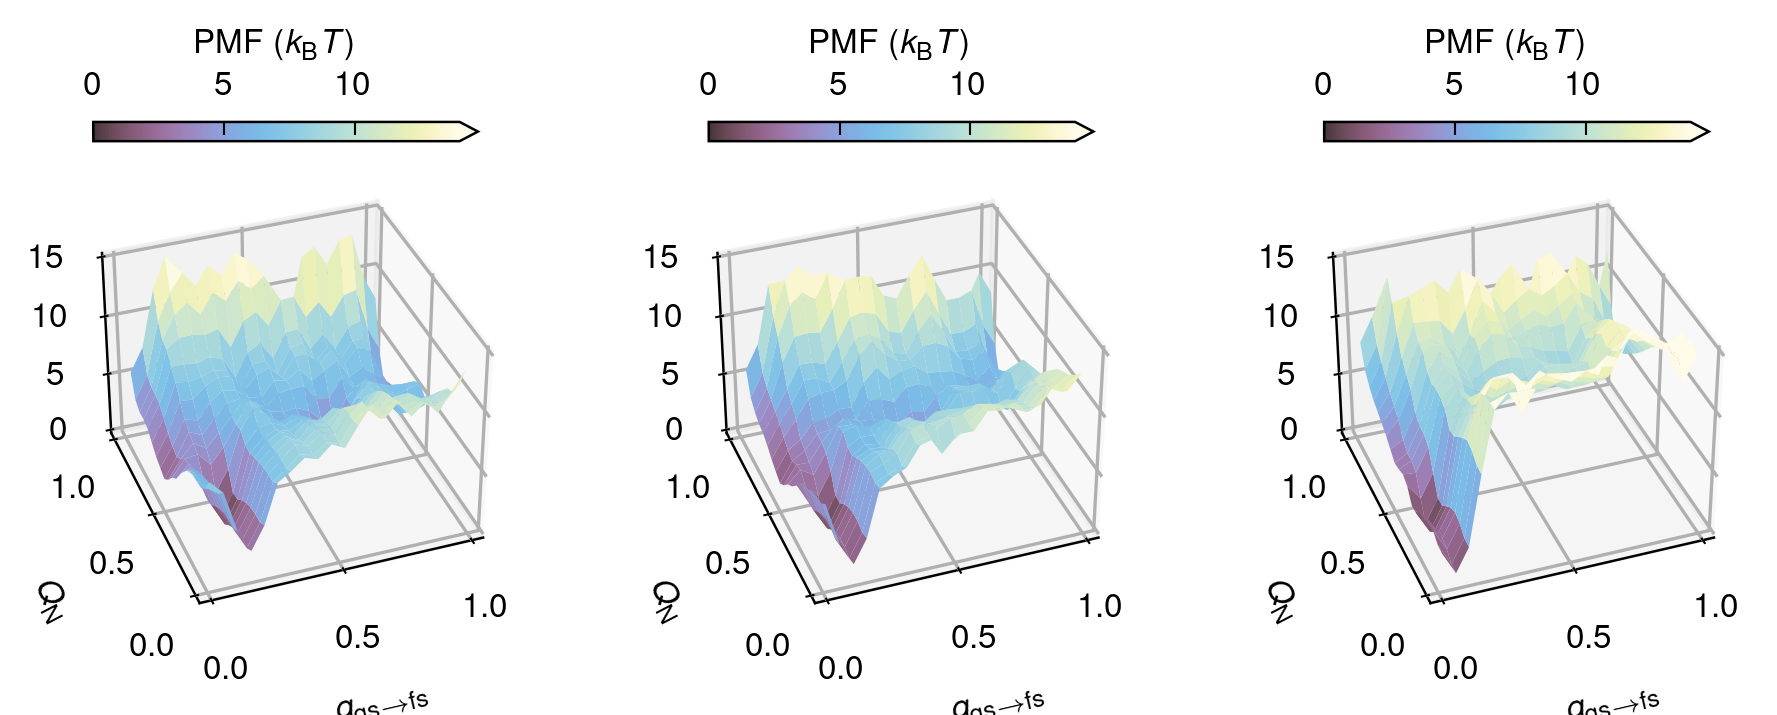

In [70]:
cv2 = "q_core"
fig, axes = plt.subplots(1, 3, dpi=300, figsize=(7.5, 2.5), subplot_kw={"projection": "3d"})
xe = np.linspace(0, 1, 21)
ye = np.linspace(*lims[cv2], 21)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
gszs = [3, 3, 3]
fszs = [6, 7, 9]
for ax, cvs, sample_w, qp, gsz, fsz in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts, gszs, fszs):
    cv1_delay = qp
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv2_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.nanmin(-np.log(hist))
    pmf = np.where(pmf < 15, pmf, np.nan)

    ax.set_aspect("auto")
    X, Y = np.meshgrid(xc, yc)
    pc = ax.plot_surface(X, Y, pmf.T, cmap="iridescent_r", vmin=0, vmax=14)
    ax.tick_params(axis="both", which="major", pad=0.5)
    ax.set_xlabel(labels["qp"], labelpad=0.5)
    ax.set_ylabel(labels[cv2], labelpad=0.5)
    ax.grid(True)
    ax.set_zlim([0, 15])
    cb = plt.colorbar(
        pc, ax=ax, extend="max", location="top", label=r"PMF ($k_{\mathrm{B}}T$)", shrink=0.75
    )
    ax.view_init(azim=-110, elev=35)
    # ax.text(0.1, 0.9, gsz, "gs", color='k', ha='center', va='center')
    # ax.text(0.9, 0.7, fsz, "fs", color='k', ha='center', va='center')
fig.savefig(f"{figure_dir}/pmf_3d_qp_qcore_ts.pdf", bbox_inches="tight", pad_inches=0.25)

/scratch/local/jobs/18762625/ipykernel_2538/864854385.py:20: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.nanmin(-np.log(hist))


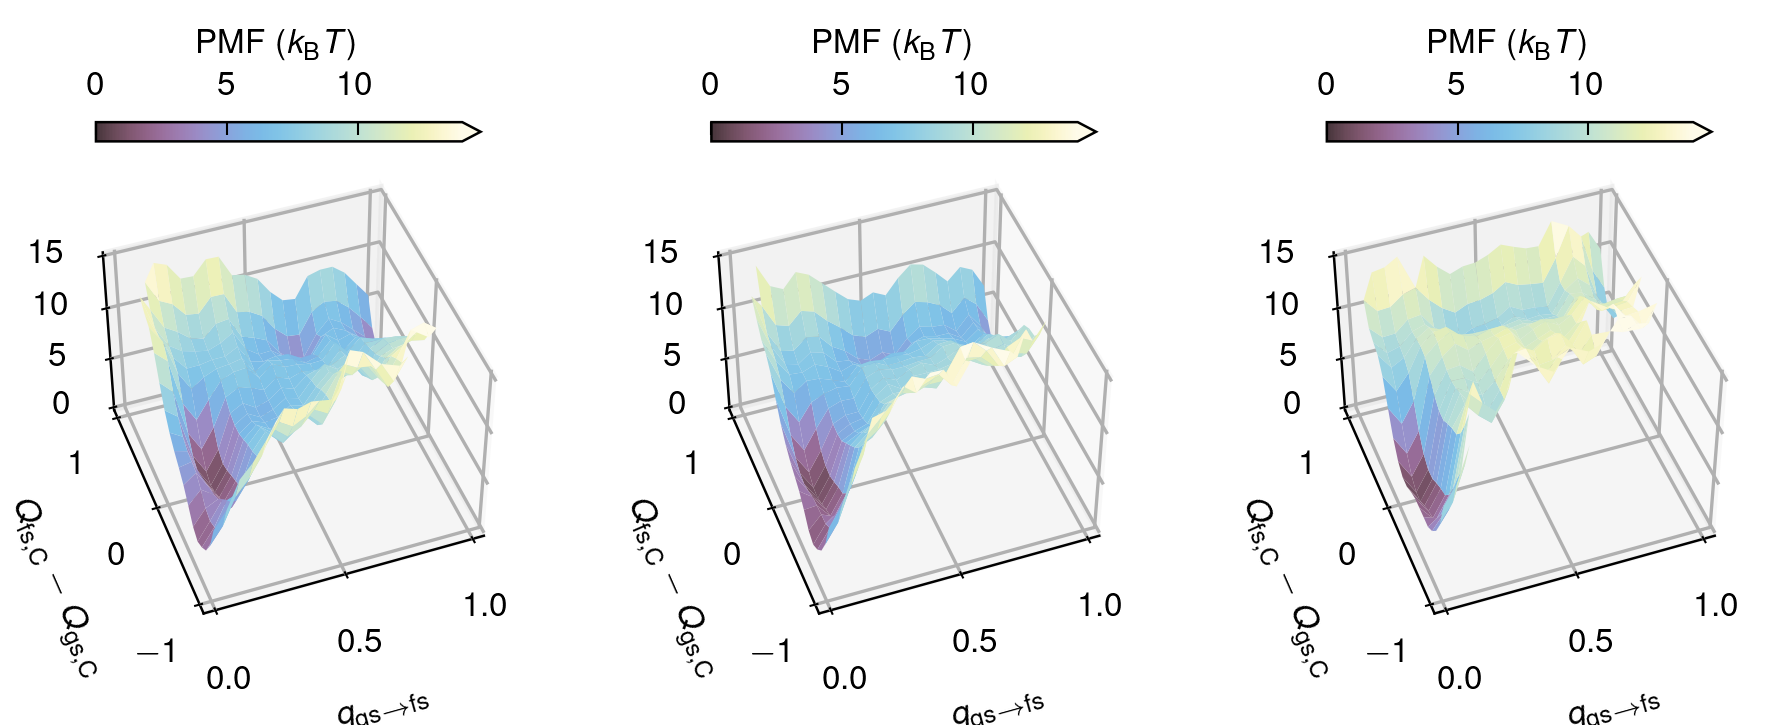

In [73]:
cv2 = "q_diff"
fig, axes = plt.subplots(1, 3, dpi=300, figsize=(7.5, 2.5), subplot_kw={"projection": "3d"})
xe = np.linspace(0, 1, 21)
ye = np.linspace(*lims[cv2], 21)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
gszs = [3, 3, 3]
fszs = [6, 7, 9]
for ax, cvs, sample_w, qp, gsz, fsz in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts, gszs, fszs):
    cv1_delay = qp
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv2_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.nanmin(-np.log(hist))
    pmf = np.where(pmf < 15, pmf, np.nan)

    ax.set_aspect("auto")
    # plane through q = 0.3
    Y, Z = np.meshgrid(np.linspace(-1, 1, 2), np.linspace(0, 15, 2))
    X_plane = np.full_like(Y, 0.3)
    # ax.plot_surface(X_plane, Y, Z, alpha=0.5, color='black', zorder=5)

    X, Y = np.meshgrid(xc, yc)
    pc = ax.plot_surface(X, Y, pmf.T, cmap="iridescent_r", vmin=0, vmax=14)
    ax.tick_params(axis="both", which="major", pad=0.5)
    ax.set_xlabel(labels["qp"], labelpad=0.5)
    ax.set_ylabel(labels[cv2], labelpad=0.5)
    ax.grid(True)
    ax.set_zlim([0, 15])
    cb = plt.colorbar(
        pc, ax=ax, extend="max", location="top", label=r"PMF ($k_{\mathrm{B}}T$)", shrink=0.75
    )
    ax.view_init(azim=-110, elev=45)
    # ax.text(0.1, 0.9, gsz, "gs", color='k', ha='center', va='center')
    # ax.text(0.9, 0.7, fsz, "fs", color='k', ha='center', va='center')
fig.savefig(f"{figure_dir}/pmf_3d_qp_qdiff_ts.pdf", bbox_inches="tight", pad_inches=0.25)

## SS

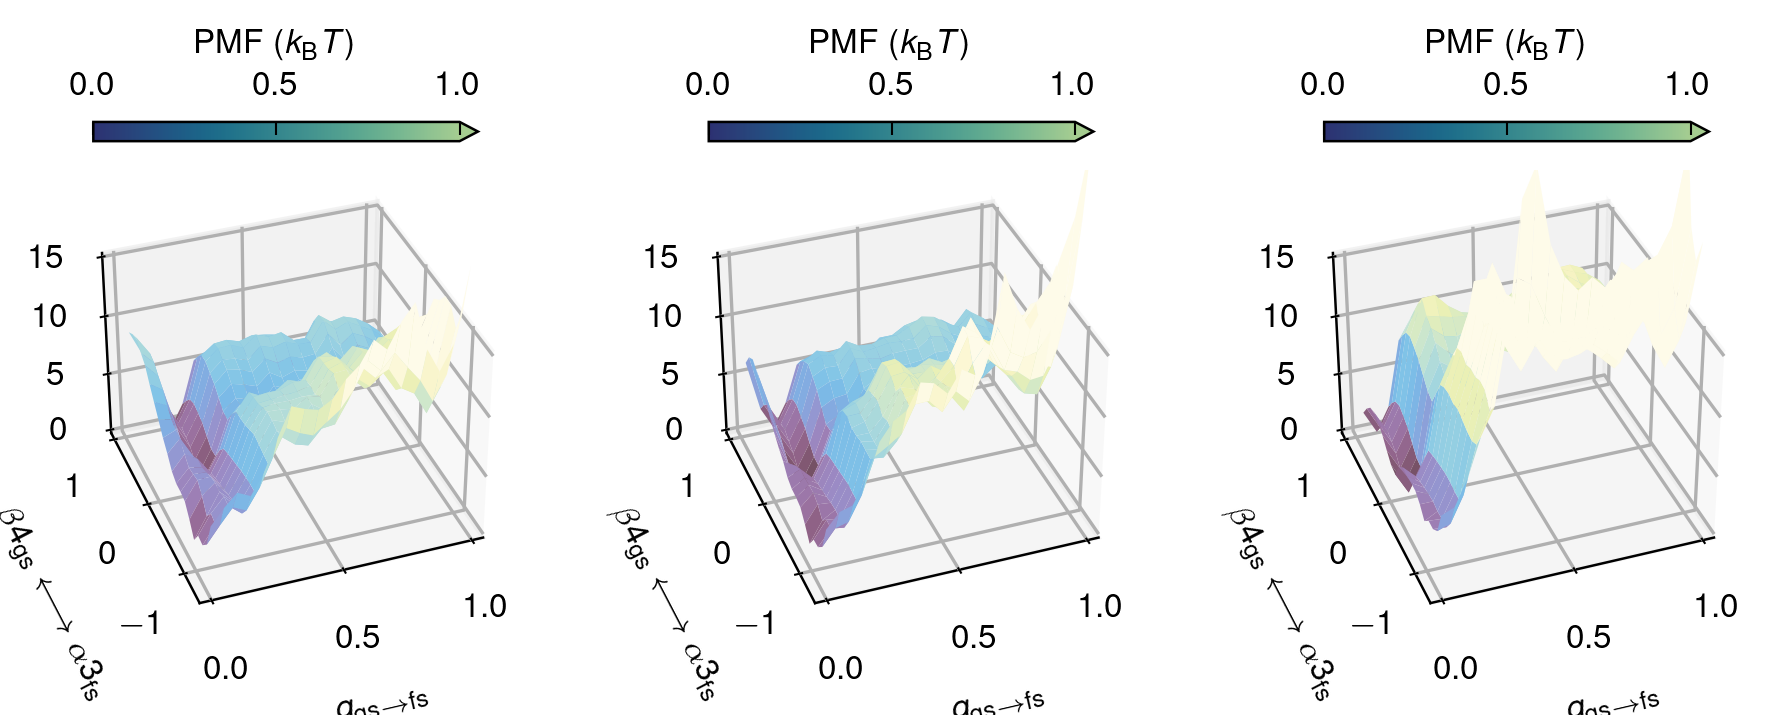

In [52]:
cv2 = "blue"
fig, axes = plt.subplots(1, 3, dpi=300, figsize=(7.5, 2.5), subplot_kw={"projection": "3d"})
xe = np.linspace(0, 1, 21)
ye = np.linspace(*lims[cv2], 21)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2

for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = qp
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv2_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode="constant")
    pmf = -np.log(hist) - np.nanmin(-np.log(hist))

    ax.set_aspect("auto")
    X, Y = np.meshgrid(xc, yc)
    pc = ax.plot_surface(X, Y, pmf.T, cmap="iridescent_r", vmin=0, vmax=14)
    ax.tick_params(axis="both", which="major", pad=0.5)
    ax.set_xlabel(labels["qp"], labelpad=0.5)
    ax.set_ylabel(labels[cv2], labelpad=0.5)
    ax.grid(True)
    ax.set_zlim([0, 15])
    cb = plt.colorbar(
        pc, ax=ax, extend="max", location="top", label=r"PMF ($k_{\mathrm{B}}T$)", shrink=0.75
    )
    ax.view_init(azim=-110, elev=35)
# fig.savefig(f"{figure_dir}/pmf_3d_qp_qdiff_ts.pdf", bbox_inches='tight', pad_inches=0.25)

/scratch/local/jobs/18762625/ipykernel_2538/3524941839.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.nanmin(-np.log(hist))


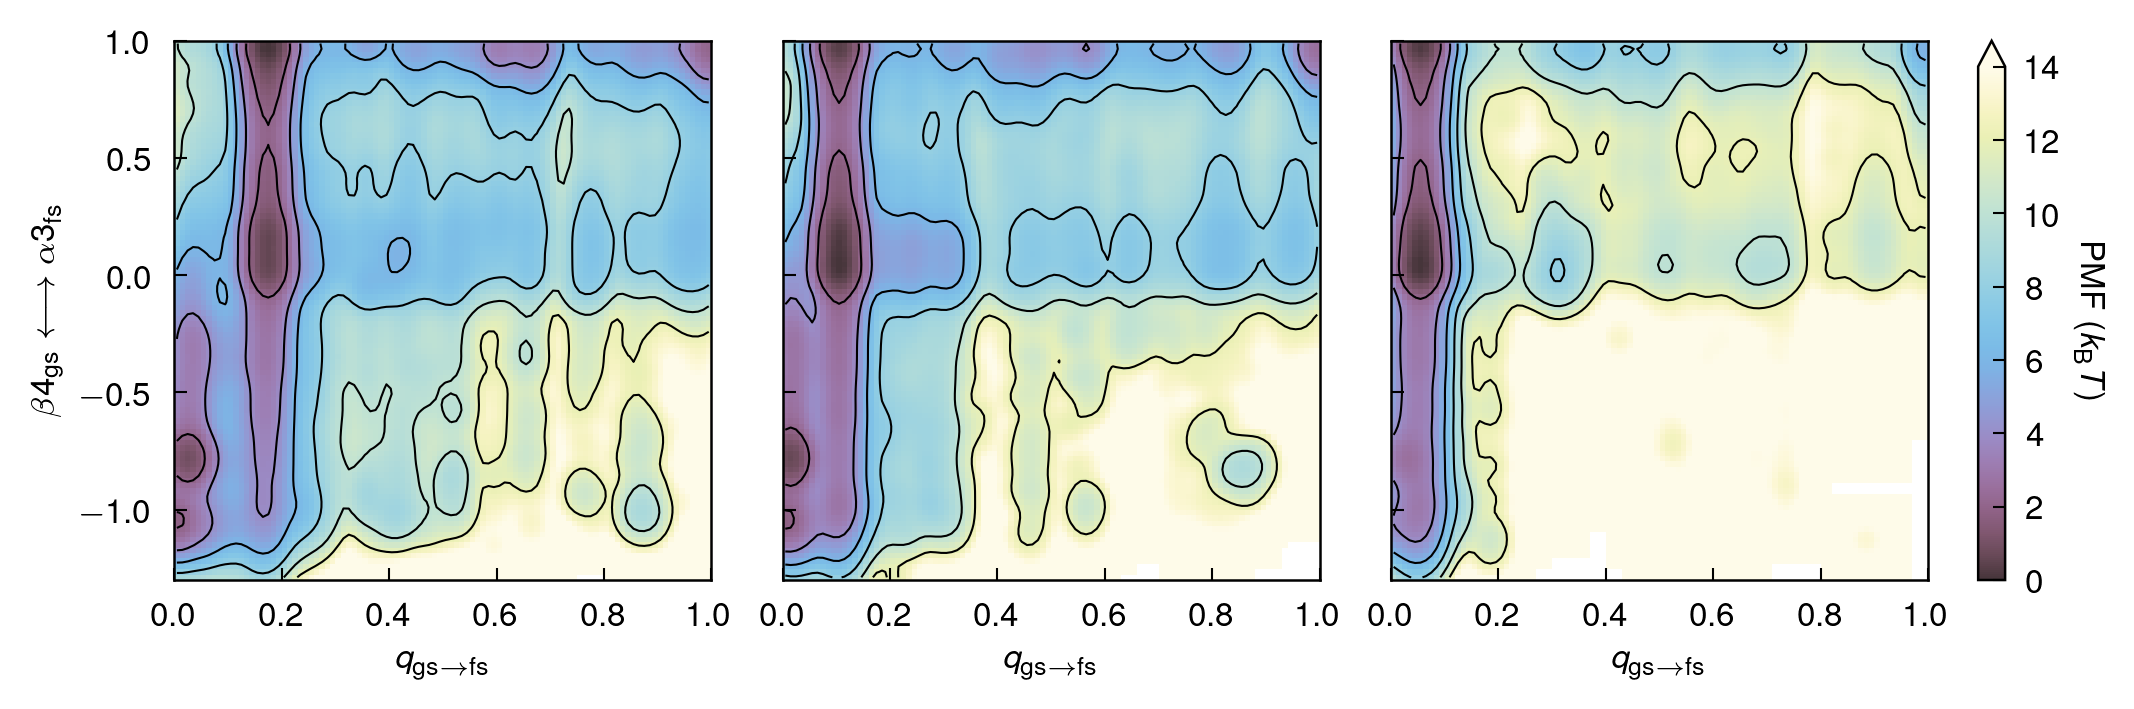

In [57]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "qp"
cv2 = "blue"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = np.asarray(qp)
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=2, mode="constant")
    pmf = -np.log(hist) - np.nanmin(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

/scratch/local/jobs/18762625/ipykernel_2538/2475822483.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.nanmin(-np.log(hist))


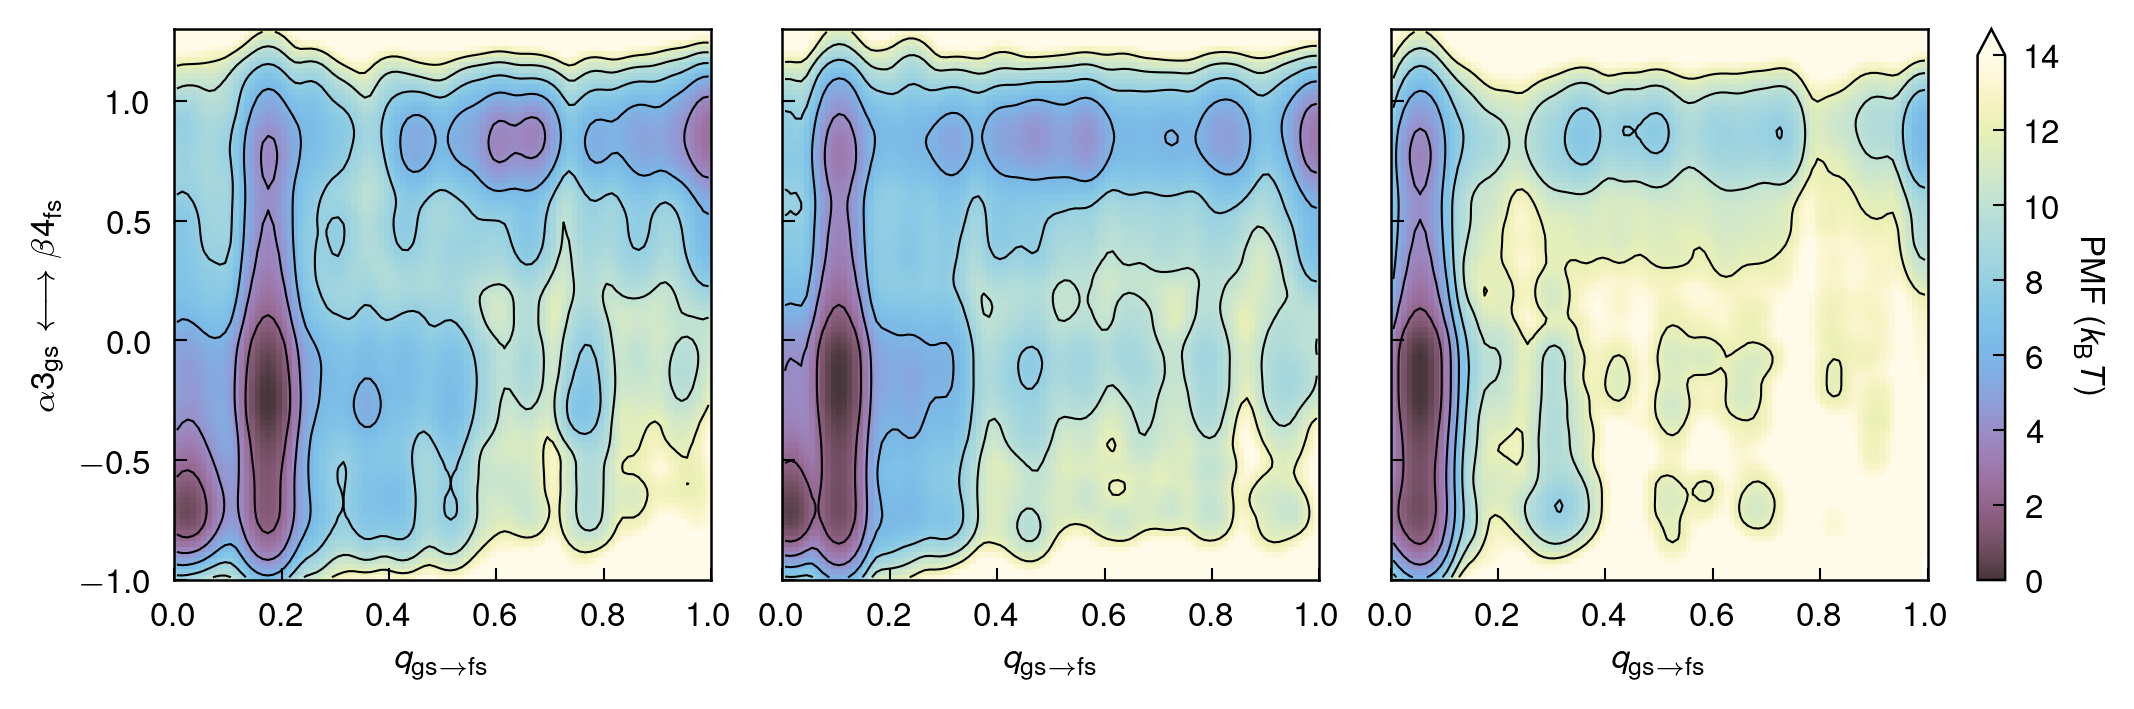

In [58]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "qp"
cv2 = "green"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = np.asarray(qp)
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=2, mode="constant")
    pmf = -np.log(hist) - np.nanmin(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

/scratch/local/jobs/18762625/ipykernel_2538/973588937.py:22: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.nanmin(-np.log(hist))


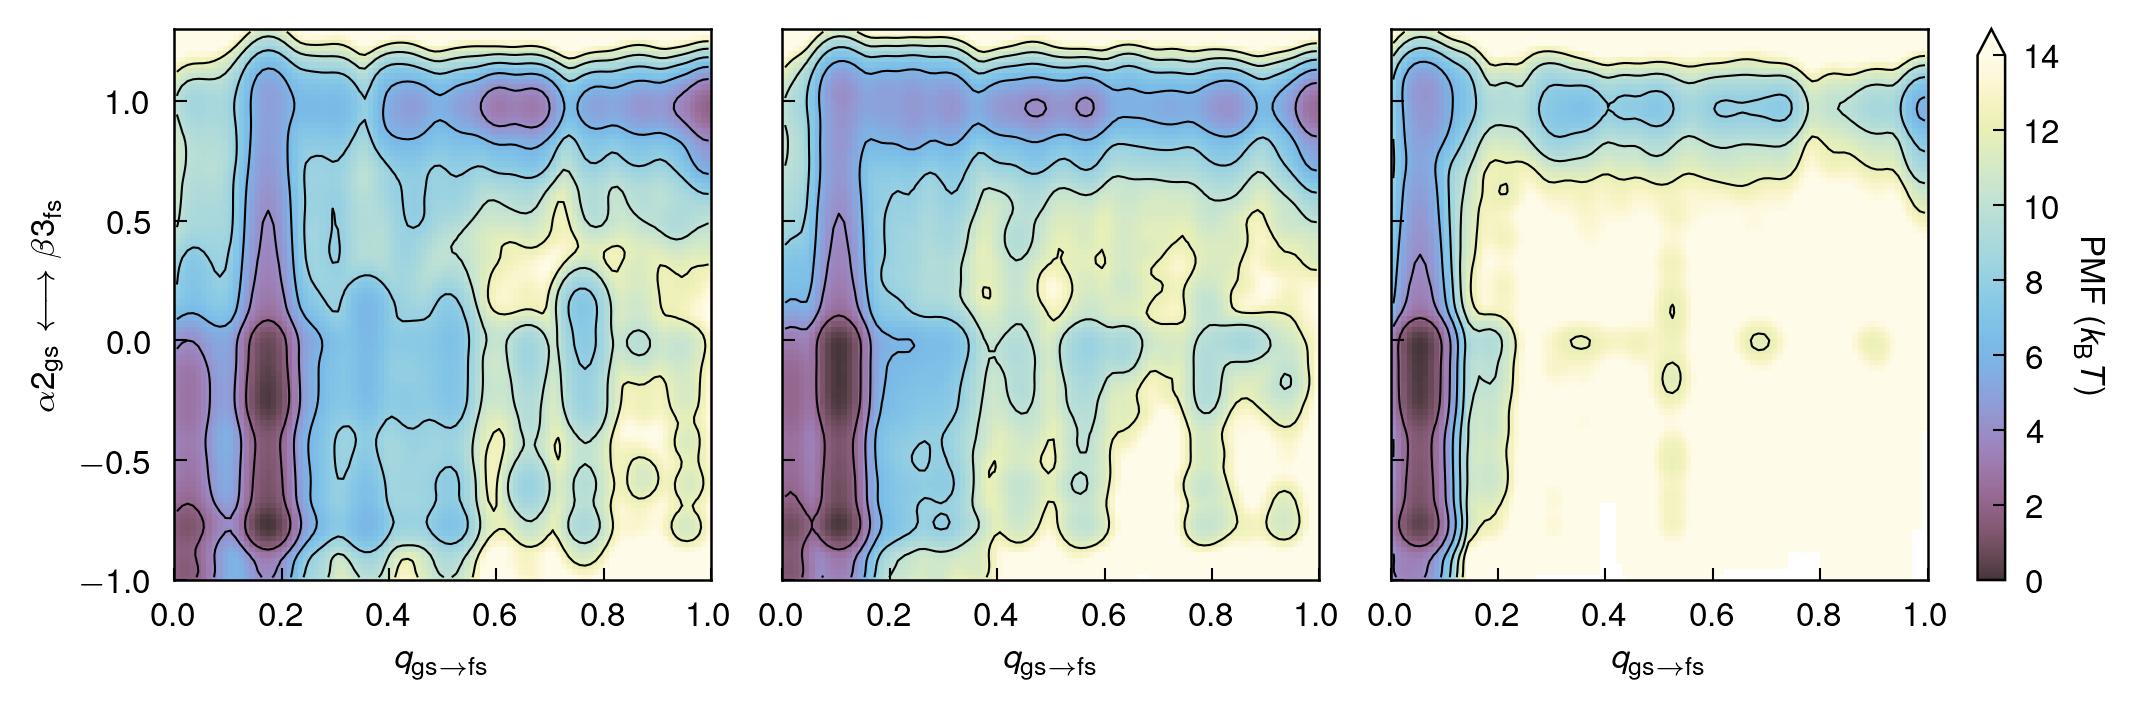

In [59]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "qp"
cv2 = "orange"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_all_ts):
    cv1_delay = np.asarray(qp)
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=2, mode="constant")
    pmf = -np.log(hist) - np.nanmin(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend="max")
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

# 1D diagrams

In [126]:
def define_states(cvs):
    in_fs = (
        (-cvs["green"] < -0.65)
        & (-cvs["blue"] < -0.8)
        & (-cvs["orange"] < -0.85)
        & (cvs["q_fs_all"] > 0.61)
        & (cvs["q_fs"] > 0.75)
        & (cvs["f_rmsds"] < 0.35)
        & (cvs["q_core"] > 0.65)
    )
    in_gs = (
        (-cvs["green"] > 0.55)
        & (-cvs["blue"] > 0.90)
        & (-cvs["orange"] > 0.75)
        & (cvs["q_gs_all"] > 0.62)
        & (cvs["q_gs"] > 0.65)
        & (cvs["p_rmsds"] < 0.45)
        & (cvs["q_core"] > 0.7)
        & (-cvs["c0"] > 0.5)
    )
    return in_fs, in_gs

In [127]:
in_fs_ts, in_gs_ts, in_d_ts = [], [], []
for cvs in cvs_all_ts:
    in_fs, in_gs = define_states(cvs)
    in_fs_ts.append(in_fs)
    in_gs_ts.append(in_gs)
    in_d_ts.append(~(in_fs | in_gs))

In [128]:
def plot_energy_path(xs, ys, name, labels=None, barwidth=1, labeloffset=0.1, color="k", ax=None):
    assert len(xs) == len(ys)
    handles = []
    if ax is None:
        ax = plt.gca()
    if labels is None:
        labels = [None for i in range(len(xs))]
    for x, y, lab in zip(xs, ys, labels):
        # plot horizontal bar
        leftx = x - barwidth / 2
        rightx = x + barwidth / 2
        (handle,) = ax.plot([leftx, rightx], [y, y], color=color, lw=3, ls="-", label=name)
        ax.annotate(
            lab, (x, y + labeloffset), color=color, verticalalignment="bottom", horizontalalignment="center"
        )
    # draw connecting lines
    for lx, ly, rx, ry in zip(xs[:-1], ys[:-1], xs[1:], ys[1:]):
        startx = lx + barwidth / 2
        endx = rx - barwidth / 2
        ax.plot([startx, endx], [ly, ry], color=color, lw=1, ls="--", alpha=0.8, zorder=1)
    return handle

-15.230476358538853 -11.050725673825811 -12.05252096605189
-14.360964912205123 -9.864895937620371 -10.559969916993689
-14.467323080774253 -7.237976853395357 -7.775109402398773


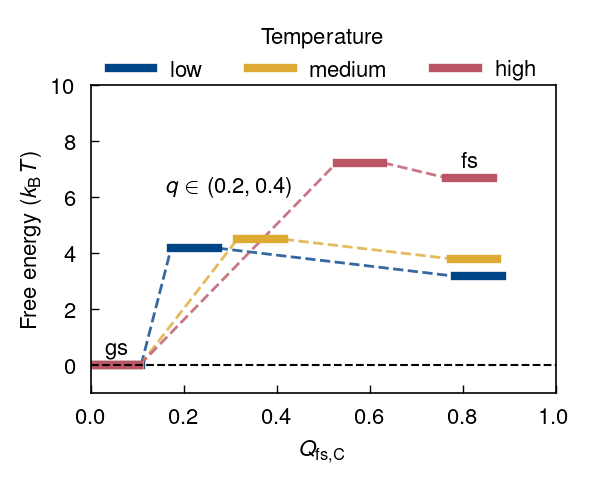

In [131]:
qmin, qmax = 0.2, 0.4
cv = "q_fs"
fig = plt.figure(figsize=(3, 2), dpi=200)
handles = []
temps = ["low", "medium", "high"]
for i, (qp, w, cvs, in_fs, in_gs, temp) in enumerate(
    zip(qp_all_ts, weights_all_ts, cvs_all_ts, in_fs_ts, in_gs_ts, temps)
):
    q = np.asarray(qp)
    g_fs = utils.g_state(w, q > 0.8)
    g_gs = utils.g_state(w, q < 0.2)
    in_tse = (q > qmin) & (q < qmax)
    g_tse = utils.g_state(w, in_tse)
    print(g_gs, g_tse, g_fs)
    g_fs -= g_gs
    g_tse -= g_gs

    cv_fs = utils.pi_avg_state(cvs[cv], w, in_fs)
    cv_gs = utils.pi_avg_state(cvs[cv], w, in_gs)
    cv_tse = utils.pi_avg_state(cvs[cv], w, in_tse)
    handle = plot_energy_path(
        [cv_gs, cv_tse, cv_fs],
        [0, g_tse, g_fs],
        temp,
        labels=["", "", ""],
        barwidth=0.1,
        labeloffset=0.2,
        color=f"C{i}",
    )
    handles.append(handle)
plt.annotate("gs", (cv_gs, 0.2), color="black", verticalalignment="bottom", horizontalalignment="center")
plt.annotate(
    r"$q\in(0.2, 0.4)$", (0.3, 6), color="black", verticalalignment="bottom", horizontalalignment="center"
)
plt.annotate(
    "fs", (cv_fs, g_fs + 0.2), color="black", verticalalignment="bottom", horizontalalignment="center"
)
plt.axhline(0, ls="--", color="k")
plt.xlim([0, 1])
plt.ylim([-1, 10])
plt.xlabel(labels[cv])
plt.ylabel(r"Free energy ($k_{\mathrm{B}}T$)")
plt.legend(
    handles,
    temps,
    title="Temperature",
    bbox_to_anchor=(0.5, 1.1),
    loc="center",
    ncols=3,
)
plt.savefig(f"{figure_dir}/fe_diagram_qfs.pdf", bbox_inches="tight")

-15.230476358538853 -11.050725673825811 -12.05252096605189
-14.360964912205123 -9.864895937620371 -10.559969916993689
-14.467323080774253 -7.237976853395357 -7.775109402398773


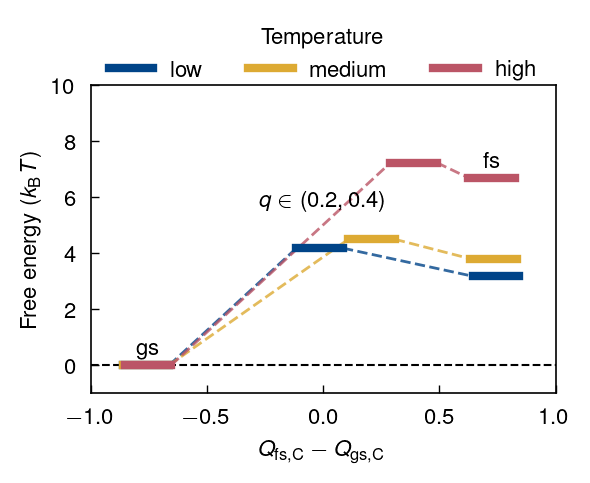

In [134]:
qmin, qmax = 0.2, 0.4
cv = "q_diff"
fig = plt.figure(figsize=(3, 2), dpi=200)
handles = []
temps = ["low", "medium", "high"]
for i, (qp, w, cvs, in_fs, in_gs, temp) in enumerate(
    zip(qp_all_ts, weights_all_ts, cvs_all_ts, in_fs_ts, in_gs_ts, temps)
):
    q = np.asarray(qp)
    g_fs = utils.g_state(w, q > 0.8)
    g_gs = utils.g_state(w, q < 0.2)
    in_tse = (q > qmin) & (q < qmax)
    g_tse = utils.g_state(w, in_tse)
    print(g_gs, g_tse, g_fs)
    g_fs -= g_gs
    g_tse -= g_gs

    cv_fs = utils.pi_avg_state(cvs[cv], w, in_fs)
    cv_gs = utils.pi_avg_state(cvs[cv], w, in_gs)
    cv_tse = utils.pi_avg_state(cvs[cv], w, in_tse)
    handle = plot_energy_path(
        [cv_gs, cv_tse, cv_fs],
        [0, g_tse, g_fs],
        temp,
        labels=["", "", ""],
        barwidth=0.2,
        labeloffset=0.2,
        color=f"C{i}",
    )
    handles.append(handle)
plt.annotate("gs", (cv_gs, 0.2), color="black", verticalalignment="bottom", horizontalalignment="center")
plt.annotate(
    r"$q\in(0.2, 0.4)$", (0, 5.5), color="black", verticalalignment="bottom", horizontalalignment="center"
)
plt.annotate(
    "fs", (cv_fs, g_fs + 0.2), color="black", verticalalignment="bottom", horizontalalignment="center"
)
plt.axhline(0, ls="--", color="k", zorder=0)
plt.xlim(*lims[cv])
plt.ylim([-1, 10])
plt.xlabel(labels[cv])
plt.ylabel(r"Free energy ($k_{\mathrm{B}}T$)")
plt.legend(
    handles,
    temps,
    title="Temperature",
    bbox_to_anchor=(0.5, 1.1),
    loc="center",
    ncols=3,
)
plt.savefig(f"{figure_dir}/fe_diagram_qdiff.pdf", bbox_inches="tight")

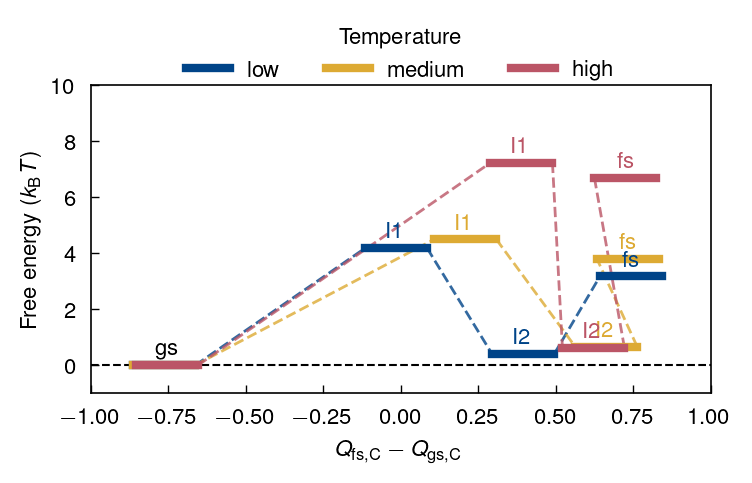

In [23]:
qmin, qmax = 0.2, 0.4
cv = "q_diff"
fig = plt.figure(figsize=(4, 2), dpi=200)
handles = []
temps = ["low", "medium", "high"]
for i, (qp, w, cvs, in_fs, in_gs, temp) in enumerate(
    zip(qp_all_ts, weights_all_ts, cvs_all_ts, in_fs_ts, in_gs_ts, temps)
):
    q = np.asarray(qp)
    g_fs = utils.g_state(w, q > 0.8)
    g_gs = utils.g_state(w, q < 0.2)
    in_tse = (q > qmin) & (q < qmax)
    in_tse2 = (q > 0.4) & (q < 0.6)
    g_tse = utils.g_state(w, in_tse)
    g_tse2 = utils.g_state(w, in_tse2)
    g_fs -= g_gs
    g_tse -= g_gs
    g_tse2 -= g_gs

    cv_fs = utils.pi_avg_state(cvs[cv], w, in_fs)
    cv_gs = utils.pi_avg_state(cvs[cv], w, in_gs)
    cv_tse = utils.pi_avg_state(cvs[cv], w, in_tse)
    cv_tse2 = utils.pi_avg_state(cvs[cv], w, in_tse2)
    handle = plot_energy_path(
        [cv_gs, cv_tse, cv_tse2, cv_fs],
        [0, g_tse, cv_tse2, g_fs],
        temp,
        labels=["", "I1", "I2", "fs"],
        barwidth=0.2,
        labeloffset=0.2,
        color=f"C{i}",
    )
    handles.append(handle)
plt.annotate("gs", (cv_gs, 0.2), color="black", verticalalignment="bottom", horizontalalignment="center")
plt.axhline(0, ls="--", color="k", zorder=0)
plt.xlim(*lims[cv])
plt.ylim([-1, 10])
plt.xlabel(labels[cv])
plt.ylabel(r"Free energy ($k_{\mathrm{B}}T$)")
plt.legend(
    handles,
    temps,
    title="Temperature",
    bbox_to_anchor=(0.5, 1.1),
    loc="center",
    ncols=3,
)
# plt.savefig(f"{figure_dir}/fe_diagram_qdiff.pdf", bbox_inches='tight')

-15.230476358538853 -11.050725673825811 -12.05252096605189
-14.360964912205123 -9.864895937620371 -10.559969916993689
-14.467323080774253 -7.237976853395357 -7.775109402398773


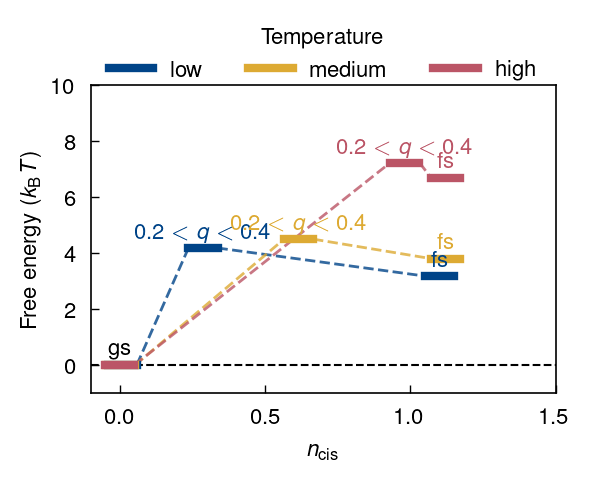

In [24]:
qmin, qmax = 0.2, 0.4
cv = "n_cis"
fig = plt.figure(figsize=(3, 2), dpi=200)
handles = []
temps = ["low", "medium", "high"]
for i, (qp, w, cvs, in_fs, in_gs, temp) in enumerate(
    zip(qp_all_ts, weights_all_ts, cvs_all_ts, in_fs_ts, in_gs_ts, temps)
):
    q = np.asarray(qp)
    g_fs = utils.g_state(w, q > 0.8)
    g_gs = utils.g_state(w, q < 0.2)
    in_tse = (q > qmin) & (q < qmax)
    g_tse = utils.g_state(w, in_tse)
    print(g_gs, g_tse, g_fs)
    g_fs -= g_gs
    g_tse -= g_gs

    cv_fs = utils.pi_avg_state(cvs[cv], w, in_fs)
    cv_gs = utils.pi_avg_state(cvs[cv], w, in_gs)
    cv_tse = utils.pi_avg_state(cvs[cv], w, in_tse)
    handle = plot_energy_path(
        [cv_gs, cv_tse, cv_fs],
        [0, g_tse, g_fs],
        temp,
        labels=["", r"$0.2 < q < 0.4$", "fs"],
        barwidth=0.1,
        labeloffset=0.2,
        color=f"C{i}",
    )
    handles.append(handle)
plt.annotate("gs", (cv_gs, 0.2), color="black", verticalalignment="bottom", horizontalalignment="center")
plt.axhline(0, ls="--", color="k", zorder=0)
plt.xlim([-0.1, 1.5])
plt.ylim([-1, 10])
plt.xlabel(labels[cv])
plt.ylabel(r"Free energy ($k_{\mathrm{B}}T$)")
plt.legend(
    handles,
    temps,
    title="Temperature",
    bbox_to_anchor=(0.5, 1.1),
    loc="center",
    ncols=3,
)
plt.savefig(f"{figure_dir}/fe_diagram_ncis.pdf", bbox_inches="tight")

# Fluxes

In [26]:
def load_rates():
    rates_ts_gs2fs, rates_withc_ts_gs2fs, rates_ts_fs2gs, rates_withc_ts_fs2gs = [], [], [], []
    for temp in (87, 89, 91):
        base_dir = f"{home_dir}/dga/new_{temp}"
        data_dir = f"{base_dir}/data"
        rates_ts_gs2fs.append(np.load(f"{data_dir}/rates_gs2fs.npy"))
        rates_withc_ts_gs2fs.append(np.load(f"{data_dir}/rates_gs2fs_withc.npy"))
        rates_ts_fs2gs.append(np.load(f"{data_dir}/rates_fs2gs.npy"))
        rates_withc_ts_fs2gs.append(np.load(f"{data_dir}/rates_fs2gs_withc.npy"))
    return rates_ts_gs2fs, rates_withc_ts_gs2fs, rates_ts_fs2gs, rates_withc_ts_fs2gs

In [27]:
rates_ts_gs2fs, rates_withc_ts_gs2fs, rates_ts_fs2gs, rates_withc_ts_fs2gs = load_rates()

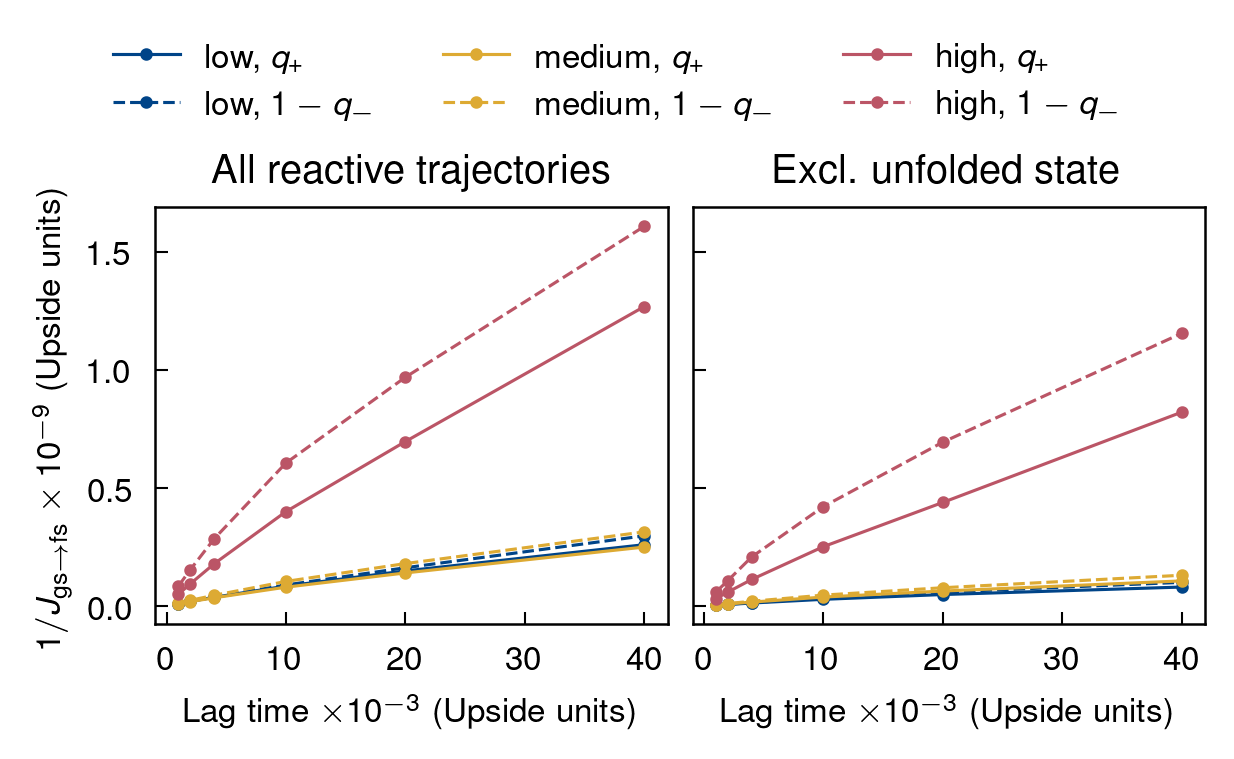

In [40]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(4, 2), sharex=True, sharey=True, constrained_layout=True)
lags = np.array([5, 10, 20, 50, 100, 200], dtype=int)

linestyles = ["-", "--"]
colors = ["C0", "C1", "C2"]
Ts = ["low", "medium", "high"]
rcs = [r"$q_+$", r"$1 - q_-$"]
for r_gs2fs, r_gs2fs_withc, c, T in zip(rates_ts_gs2fs, rates_withc_ts_gs2fs, colors, Ts):
    for r, r_withc, ls, rc in zip(r_gs2fs, r_gs2fs_withc, linestyles, rcs):
        percent_through = r_withc / (r_withc + r)
        axes[0].plot(lags * 200 * 1e-3, 1 / r * 200 * 1e-9, ls=ls, color=c, marker="o", label=f"{T}, {rc}")
        axes[1].plot(lags * 200 * 1e-3, 1 / r_withc * 200 * 1e-9, ls=ls, color=c, marker="o")
for ax in axes:
    ax.set_xlabel(r"Lag time $\times 10^{-3}$ (Upside units)")
    ax.set_ylabel(r"$1 / J_{\mathrm{gs}\rightarrow\mathrm{fs}} \times 10^{-9}$ (Upside units)")
    ax.label_outer()
axes[0].set_title("All reactive trajectories")
axes[1].set_title("Excl. unfolded state")
fig.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3)
fig.savefig(f"{figure_dir}/reactive_flux_both.pdf", bbox_inches="tight")

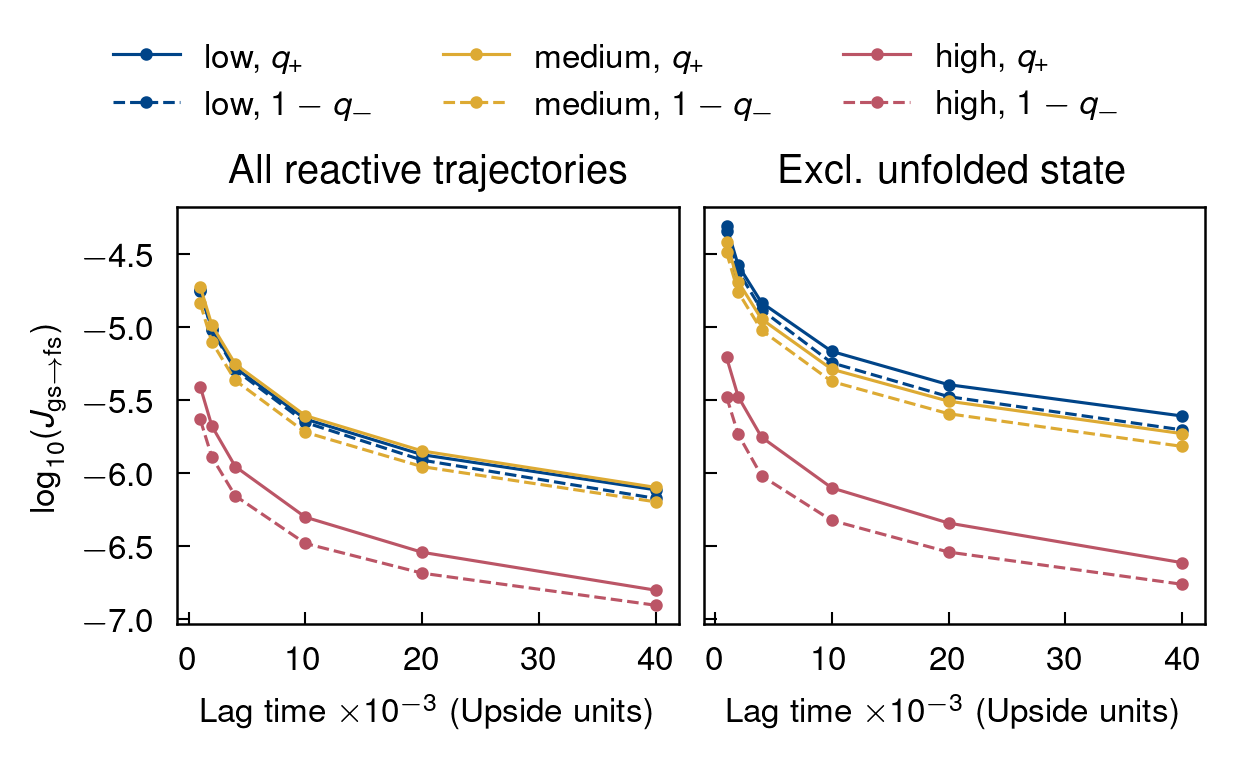

In [43]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(4, 2), sharex=True, sharey=True, constrained_layout=True)
lags = np.array([5, 10, 20, 50, 100, 200], dtype=int)

linestyles = ["-", "--"]
colors = ["C0", "C1", "C2"]
Ts = ["low", "medium", "high"]
rcs = [r"$q_+$", r"$1 - q_-$"]
for r_gs2fs, r_gs2fs_withc, c, T in zip(rates_ts_gs2fs, rates_withc_ts_gs2fs, colors, Ts):
    for r, r_withc, ls, rc in zip(r_gs2fs, r_gs2fs_withc, linestyles, rcs):
        percent_through = r_withc / (r_withc + r)
        axes[0].plot(lags * 200 * 1e-3, np.log10(r), ls=ls, color=c, marker="o", label=f"{T}, {rc}")
        axes[1].plot(lags * 200 * 1e-3, np.log10(r_withc), ls=ls, color=c, marker="o")
for ax in axes:
    ax.set_xlabel(r"Lag time $\times 10^{-3}$ (Upside units)")
    ax.set_ylabel(r"$\log_{10}(J_{\mathrm{gs}\rightarrow\mathrm{fs}})$")
    ax.label_outer()
axes[0].set_title("All reactive trajectories")
axes[1].set_title("Excl. unfolded state")
fig.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3)
fig.savefig(f"{figure_dir}/reactive_flux_log.pdf", bbox_inches="tight")

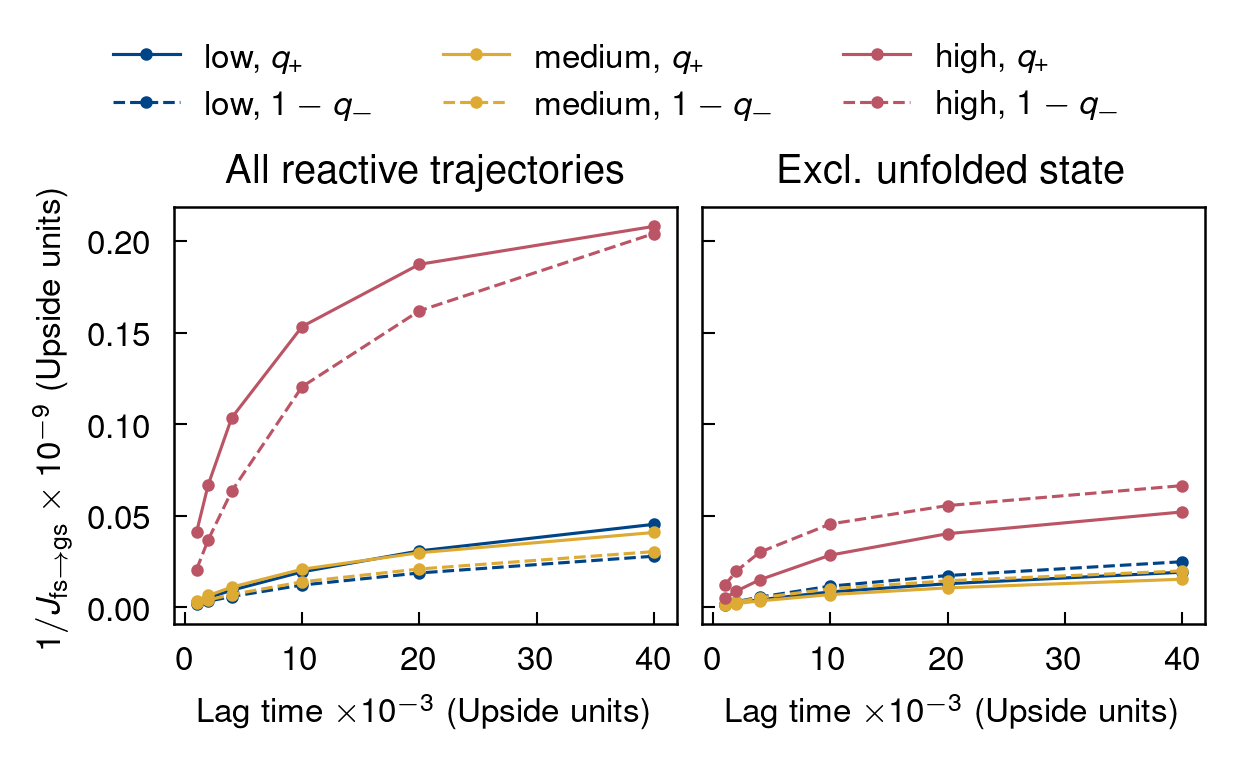

In [45]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(4, 2), sharex=True, sharey=True, constrained_layout=True)
lags = np.array([5, 10, 20, 50, 100, 200], dtype=int)

linestyles = ["-", "--"]
colors = ["C0", "C1", "C2"]
Ts = ["low", "medium", "high"]
rcs = [r"$q_+$", r"$1 - q_-$"]
for r_fs2gs, r_fs2gs_withc, c, T in zip(rates_ts_fs2gs, rates_withc_ts_fs2gs, colors, Ts):
    for r, r_withc, ls, rc in zip(r_fs2gs, r_fs2gs_withc, linestyles, rcs):
        percent_through = r_withc / (r_withc + r)
        axes[0].plot(lags * 200 * 1e-3, 1 / r * 200 * 1e-9, ls=ls, color=c, marker="o", label=f"{T}, {rc}")
        axes[1].plot(lags * 200 * 1e-3, 1 / r_withc * 200 * 1e-9, ls=ls, color=c, marker="o")
for ax in axes:
    ax.set_xlabel(r"Lag time $\times 10^{-3}$ (Upside units)")
    ax.set_ylabel(r"$1 / J_{\mathrm{fs}\rightarrow\mathrm{gs}} \times 10^{-9}$ (Upside units)")
    ax.label_outer()
axes[0].set_title("All reactive trajectories")
axes[1].set_title("Excl. unfolded state")
fig.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3)
fig.savefig(f"{figure_dir}/reactive_flux_fs2gs.pdf", bbox_inches="tight")

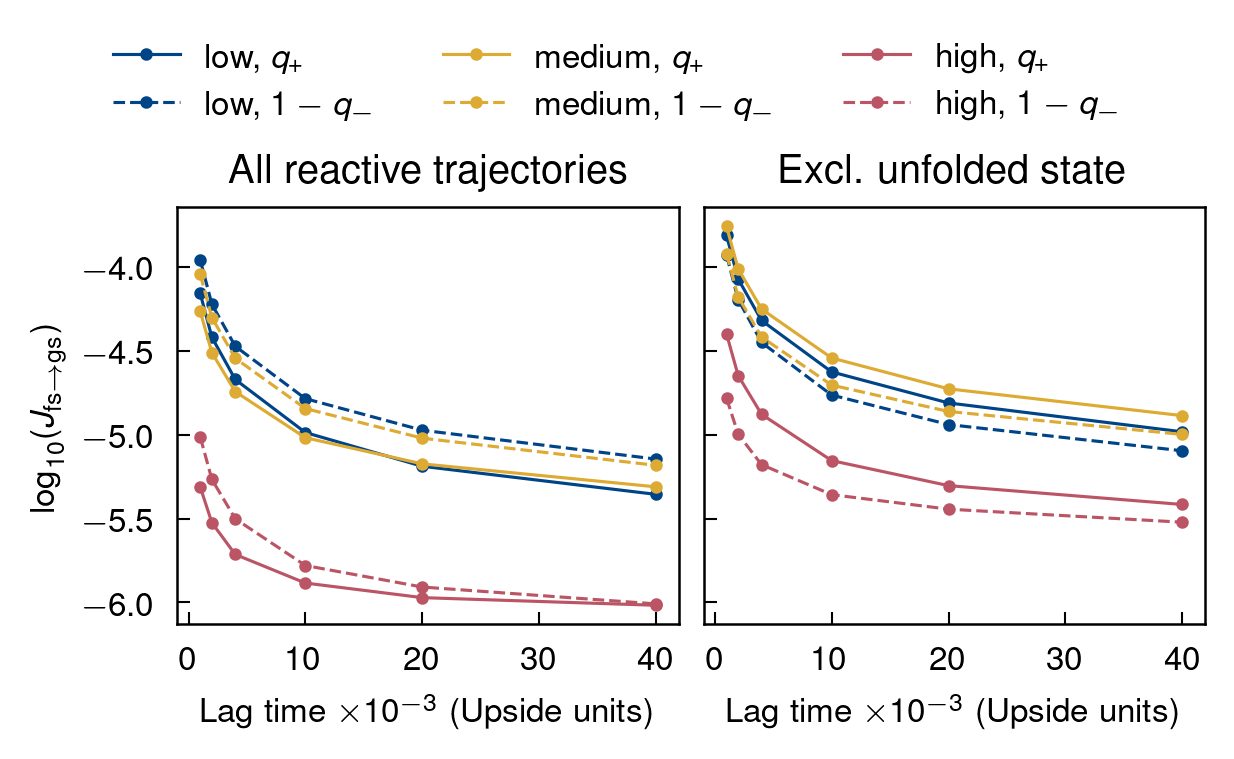

In [46]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(4, 2), sharex=True, sharey=True, constrained_layout=True)
lags = np.array([5, 10, 20, 50, 100, 200], dtype=int)

linestyles = ["-", "--"]
colors = ["C0", "C1", "C2"]
Ts = ["low", "medium", "high"]
rcs = [r"$q_+$", r"$1 - q_-$"]
for r_fs2gs, r_fs2gs_withc, c, T in zip(rates_ts_fs2gs, rates_withc_ts_fs2gs, colors, Ts):
    for r, r_withc, ls, rc in zip(r_fs2gs, r_fs2gs_withc, linestyles, rcs):
        percent_through = r_withc / (r_withc + r)
        axes[0].plot(lags * 200 * 1e-3, np.log10(r), ls=ls, color=c, marker="o", label=f"{T}, {rc}")
        axes[1].plot(lags * 200 * 1e-3, np.log10(r_withc), ls=ls, color=c, marker="o")
for ax in axes:
    ax.set_xlabel(r"Lag time $\times 10^{-3}$ (Upside units)")
    ax.set_ylabel(r"$\log_{10}(J_{\mathrm{fs}\rightarrow\mathrm{gs}})$")
    ax.label_outer()
axes[0].set_title("All reactive trajectories")
axes[1].set_title("Excl. unfolded state")
fig.legend(bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3)
fig.savefig(f"{figure_dir}/reactive_flux_log_fs2gs.pdf", bbox_inches="tight")

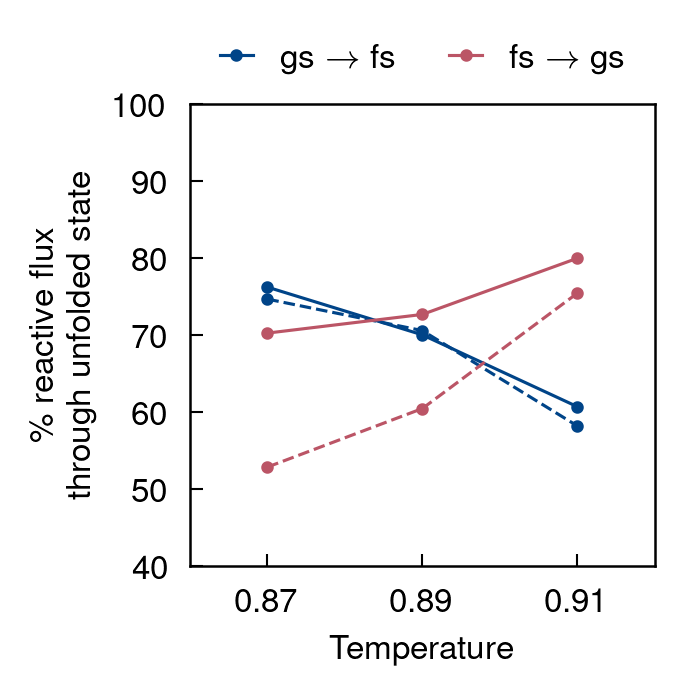

In [41]:
fig = plt.figure(dpi=300, figsize=(2, 2))
Ts = [0.87, 0.89, 0.91]
ratios_gs2fs, ratios_fs2gs = [], []
for r_gs2fs, r_gs2fs_withc in zip(rates_ts_gs2fs, rates_withc_ts_gs2fs):
    r = r_gs2fs[:, -1]  # qp as rc
    r_withc = r_gs2fs_withc[:, -1]
    percent_through = r_withc / (r_withc + r)
    ratios_gs2fs.append(percent_through)
for r_fs2gs, r_fs2gs_withc in zip(rates_ts_fs2gs, rates_withc_ts_fs2gs):
    r = r_fs2gs[:, -1]  # qp as rc
    r_withc = r_fs2gs_withc[:, -1]
    percent_through = r_withc / (r_withc + r)
    ratios_fs2gs.append(percent_through)

plt.plot(
    Ts,
    np.array(ratios_gs2fs)[:, 0] * 100,
    "-o",
    color="C0",
    label=r"$\mathrm{gs}\rightarrow\mathrm{fs}$",
)
plt.plot(Ts, np.array(ratios_gs2fs)[:, 1] * 100, "--o", color="C0")
plt.plot(
    Ts,
    np.array(ratios_fs2gs)[:, 0] * 100,
    "-o",
    color="C2",
    label=r"$\mathrm{fs}\rightarrow\mathrm{gs}$",
)
plt.plot(Ts, np.array(ratios_fs2gs)[:, 1] * 100, "--o", color="C2")
plt.xlabel("Temperature")
plt.ylabel("\% reactive flux\nthrough unfolded state")
plt.xticks(ticks=Ts)
plt.xlim([0.86, 0.92])
plt.ylim([40, 100])
pplt.legend(outside="top", handlelength=1)
plt.show()
fig.savefig(f"{figure_dir}/flux_ratio_ts.pdf", bbox_inches="tight")